In [2]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.utils import is_undirected, to_undirected

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax



In [3]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [3]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

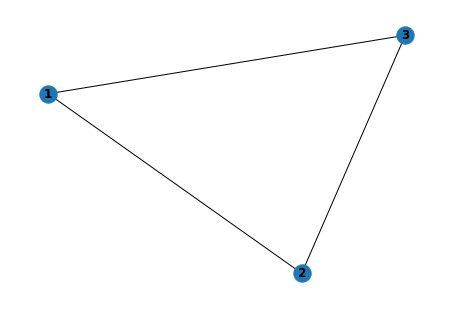

In [4]:
nx.draw(G1, with_labels=True, font_weight='bold')

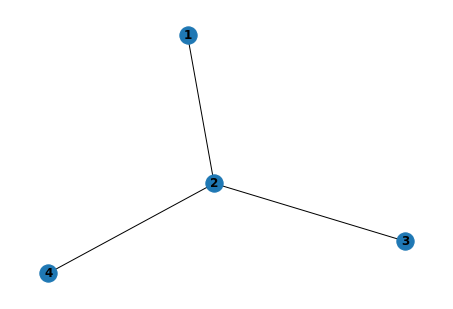

In [5]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

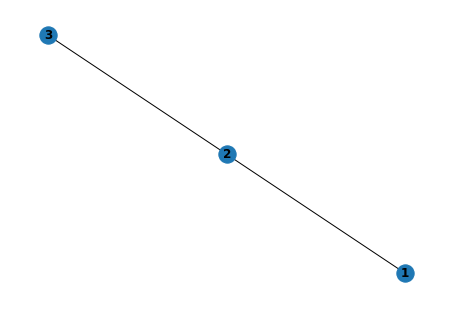

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [7]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [8]:
n_basis, n_shapes = 2000, 200

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [9]:
plugins

array([1748,  577, 1584, 1135, 1778,  596,  734,  968, 1941,  877, 1332,
       1496, 1686,  485, 1003,  923, 1464, 1441,  160,  132, 1375, 1429,
       1418, 1700, 1336, 1447,  718,  887, 1629,   14, 1474, 1014,  351,
        109,  167, 1296, 1754,  163,  537,  478,  183,  989, 1551,  439,
       1681, 1698, 1275,  844, 1861,  627, 1723,  528, 1682, 1838,  837,
        446, 1611, 1489, 1708,   64,  135, 1745,  223,   68,  372,  320,
       1793, 1069, 1872,  309,  378,  592,  733, 1808, 1192,  561, 1411,
        880,  248,  173,  787, 1991,  333,  364,  976, 1600,  564,   29,
        124, 1363, 1389, 1858,  237, 1744,  623,  730, 1617,  698, 1985,
        434, 1425,  886,  188, 1021,  541,  464,  192, 1897, 1338,  824,
       1175,  775, 1146, 1076,   37,  490,  958, 1851, 1925,  884,   89,
       1191, 1151,  148, 1271,  335,  371, 1910, 1045, 1651,  694, 1200,
       1480,  558, 1145, 1260, 1416, 1138,  144,  779, 1233, 1950,  642,
       1141, 1350,   21, 1556,  410,  867,  337,  6

In [10]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [11]:
data = from_networkx(G, all)
data.edge_index.shape

/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch_geometric/utils/convert.py:164: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


torch.Size([2, 22750])

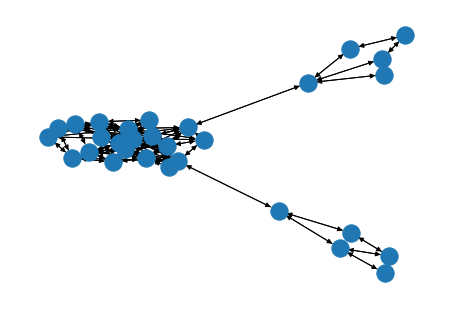

In [12]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [12]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [13]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [14]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [15]:
len(data.y[data.val_mask])

/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [12]:
nodes_sub, edge_index_sub, new_node_idx, edge_mask = k_hop_subgraph(32, 2, data.edge_index, relabel_nodes=True)
# nodes_sub is subset
# relabel_nodes changes edge_index indexation

In [13]:
new_node_idx

tensor([29])

In [41]:
mapping = {int(v): k for k, v in enumerate(subset)}
mapping

{1: 0, 30: 1, 31: 2, 32: 3, 33: 4, 34: 5}

In [40]:
nodes_sub

tensor([ 1, 30, 31, 32, 33, 34])

In [30]:
data.x[nodes_sub]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [26]:
#relabel_nodes is False
edge_index_sub

tensor([[ 1, 30, 30, 30, 31, 31, 31, 31, 32, 32, 33, 33, 34, 34],
        [31, 31, 33, 34,  1, 30, 32, 34, 31, 33, 30, 32, 30, 31]])

In [31]:
#relabel_nodes is True
edge_index_sub

tensor([[0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5],
        [2, 2, 4, 5, 0, 1, 3, 5, 2, 4, 1, 3, 1, 2]])

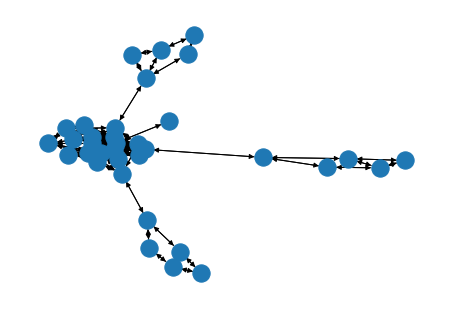

In [32]:
graph = to_networkx(data)
nx.draw(graph)

[32, 1, 33, 34, 30, 31]
[(32, 31), (32, 33), (1, 31), (33, 30), (33, 32), (34, 30), (34, 31), (30, 31), (30, 33), (30, 34), (31, 1), (31, 30), (31, 32), (31, 34)]


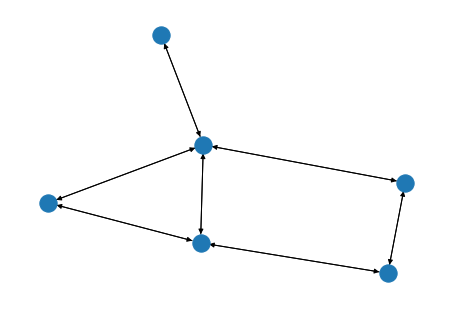

In [37]:
subset = nodes_sub
subgraph = graph.subgraph(subset.tolist())
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

[0, 1, 2, 3, 4, 5]
[(0, 2), (1, 2), (1, 4), (1, 5), (2, 0), (2, 1), (2, 3), (2, 5), (3, 2), (3, 4), (4, 1), (4, 3), (5, 1), (5, 2)]


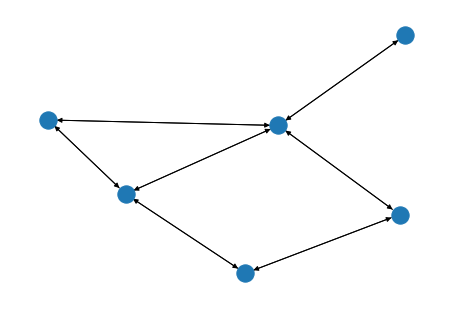

In [39]:
data_sub = Data(x=nodes_sub, edge_index=edge_index_sub)
subgraph = to_networkx(data_sub)
nx.draw(subgraph)
print(subgraph.nodes())
print(subgraph.edges())

In [177]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_layers = 2
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        
        return F.log_softmax(x, dim=1)

In [178]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_dim):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.hidden_dim = num_node_features, num_classes, num_layers, hidden_dim
        self.layers = torch.nn.ModuleList()
        current_dim = self.num_node_features
        for l in range(self.num_layers - 1):
            self.layers.append(GCNConv(current_dim, hidden_dim))
            current_dim = hidden_dim
        self.layers.append(GCNConv(current_dim, self.num_classes))

    def forward(self, x, edge_index, edge_weight=None):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.layers[-1](x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)


In [179]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, data.num_classes, 2, 16).to(device)
data = data.to(device)
print(data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

Data(edge_index=[2, 22750], x=[3000, 1], num_classes=4, y=[3000], train_mask=[3000], val_mask=[3000], test_mask=[3000])


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1776601654.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1776601654.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  Variable._execution_engine.run_backward(


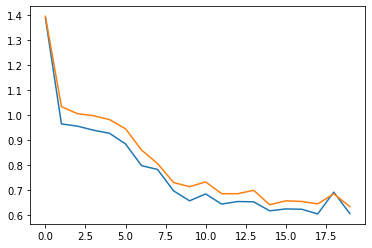

In [180]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [181]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [182]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7936


/var/folders/5m/qnq98p591m30tpzhzz2j3nwr0000gn/T/ipykernel_35997/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [56]:
edge_mask[indices] = torch.FloatTensor([1]*num_top_edges)
explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y = data.y, threshold=0.99)

NameError: name 'num_top_edges' is not defined

In [183]:
from sklearn import metrics


def get_explanation(data, edge_mask, num_top_edges=6, is_hard_mask=False):
    if is_hard_mask:
        explanation = data.edge_index[:, np.where(edge_mask == 1)[0]]
    else:
        indices = (-edge_mask).argsort()[:num_top_edges]
        explanation = data.edge_index[:, indices]

    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)

    return (G_expl)

def get_ground_truth_ba_shapes(node, data):
    base = [0, 1, 2, 3, 4]
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)

    true_node_mask = np.zeros(data.edge_index.shape[1])
    true_node_mask[ground_truth] = 1
    true_edge_mask = node_attr_to_edge(data.edge_index, true_node_mask)

    return graph, role, true_edge_mask


def scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged



In [184]:
def evaluate(node_idx, data, edge_mask, num_top_edges, is_hard_mask=False):
    G_true, role, true_edge_mask = get_ground_truth_ba_shapes(node_idx, data)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges, is_hard_mask=is_hard_mask)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    recall, precision, f1_score, ged = scores(G_expl, G_true)
    fpr, tpr, thresholds = metrics.roc_curve(true_edge_mask, edge_mask, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    return recall, precision, f1_score, ged, auc

Explain node 2000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 433.71it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


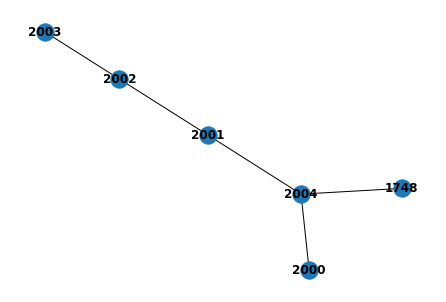

f1_score, ged 0.7272727272727272 4.0


Explain node 2001: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 415.75it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

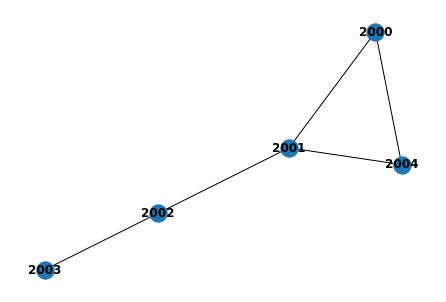

f1_score, ged 0.9090909090909091 1.0


Explain node 2002: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 413.83it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

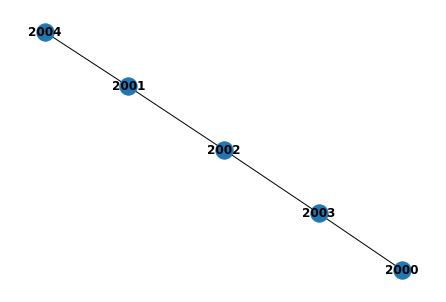

f1_score, ged 0.8 2.0


Explain node 2003: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 434.79it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

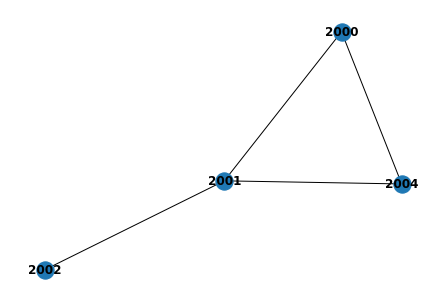

f1_score, ged 0.8 3.0


Explain node 2004: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.58it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

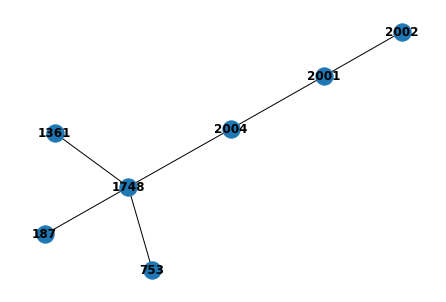

f1_score, ged 0.3333333333333333 6.0


Explain node 2005: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 579.37it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

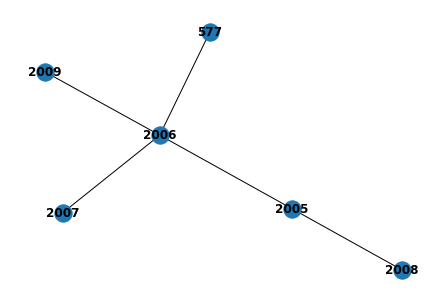

f1_score, ged 0.7272727272727272 4.0


Explain node 2006: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.98it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

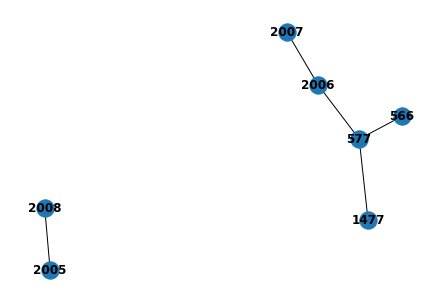

f1_score, ged 0.3636363636363636 5.0


Explain node 2007: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.31it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

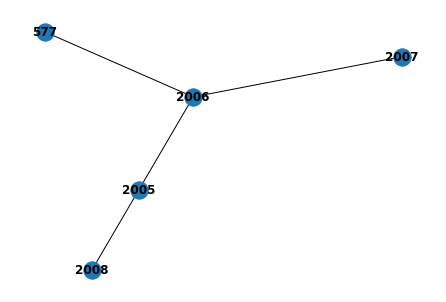

f1_score, ged 0.6 2.0


Explain node 2008: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.58it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

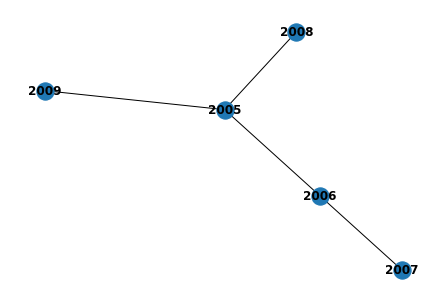

f1_score, ged 0.8 2.0


Explain node 2009: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 516.23it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

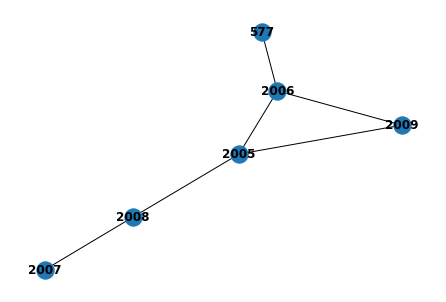

f1_score, ged 0.8333333333333334 3.0


Explain node 2010: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 510.31it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

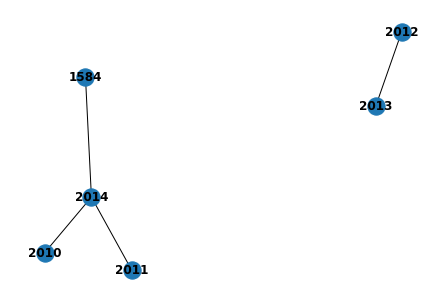

f1_score, ged 0.6 5.0


Explain node 2011: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.62it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

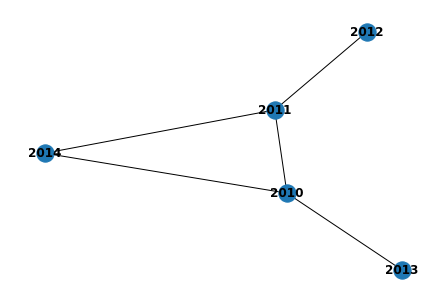

f1_score, ged 0.9090909090909091 1.0


Explain node 2012: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 473.74it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

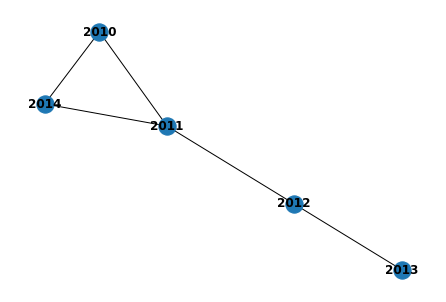

f1_score, ged 0.9090909090909091 1.0


Explain node 2013: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 491.82it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

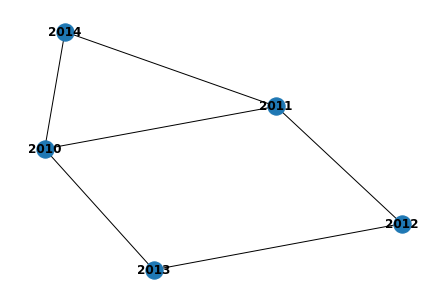

f1_score, ged 1.0 0.0


Explain node 2014: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 499.54it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

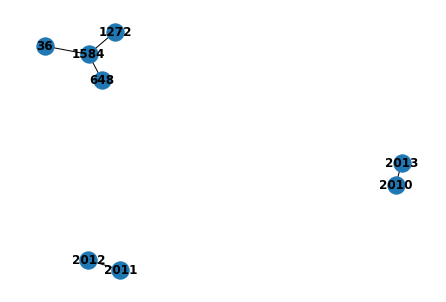

f1_score, ged 0.3636363636363636 8.0


Explain node 2015: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 498.88it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

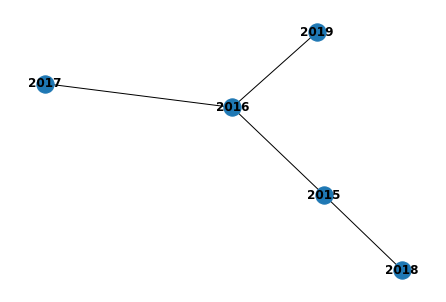

f1_score, ged 0.8 2.0


Explain node 2016: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 512.48it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

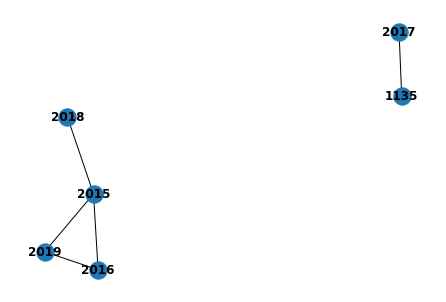

f1_score, ged 0.7272727272727272 4.0


Explain node 2017: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 573.93it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

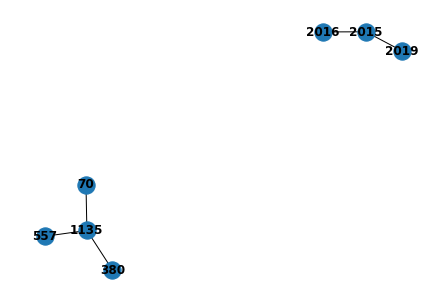

f1_score, ged 0.3636363636363636 7.0


Explain node 2018: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 415.22it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

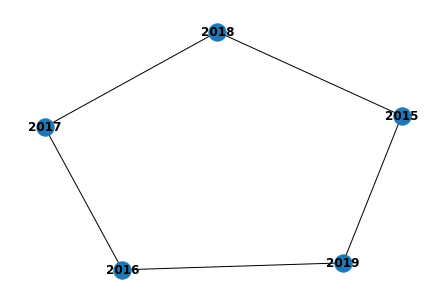

f1_score, ged 0.9090909090909091 1.0


Explain node 2019: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 394.68it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

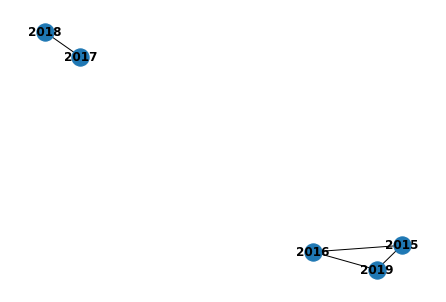

f1_score, ged 0.8 2.0


Explain node 2020: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 437.19it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

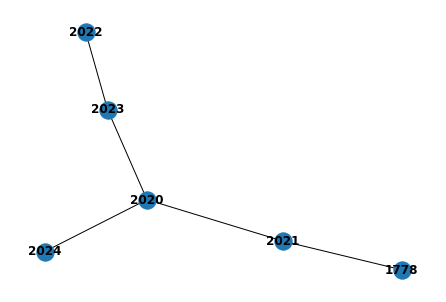

f1_score, ged 0.7272727272727272 4.0


Explain node 2021: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 411.48it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

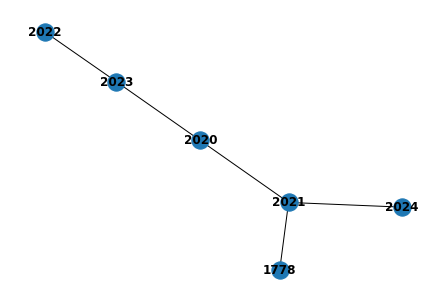

f1_score, ged 0.7272727272727272 4.0


Explain node 2022: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 444.76it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

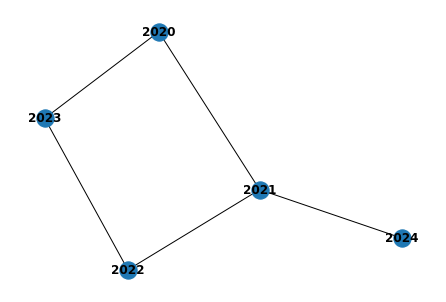

f1_score, ged 0.9090909090909091 1.0


Explain node 2023: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 367.87it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

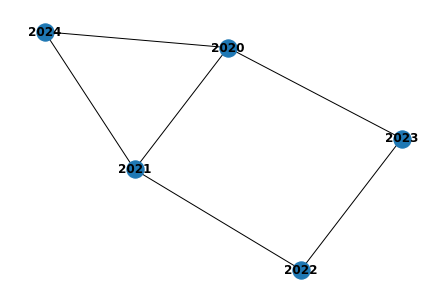

f1_score, ged 1.0 0.0


Explain node 2024: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 295.86it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

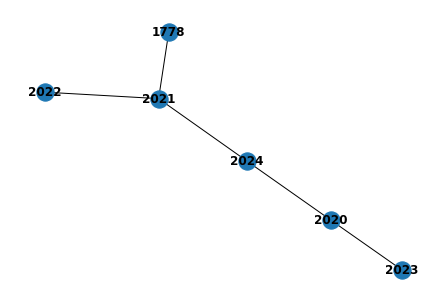

f1_score, ged 0.7272727272727272 4.0


Explain node 2025: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 391.18it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

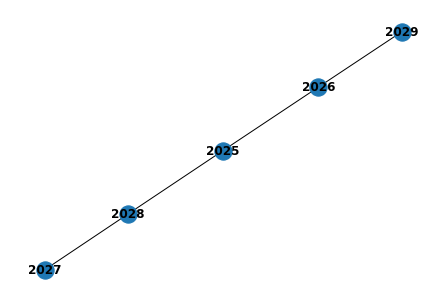

f1_score, ged 0.8 2.0


Explain node 2026: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.60it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

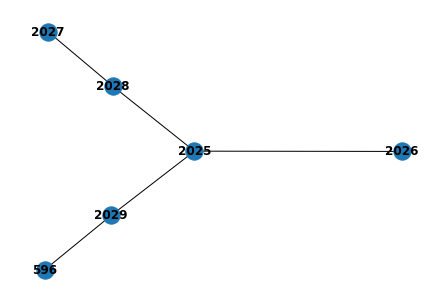

f1_score, ged 0.7272727272727272 4.0


Explain node 2027: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550.29it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

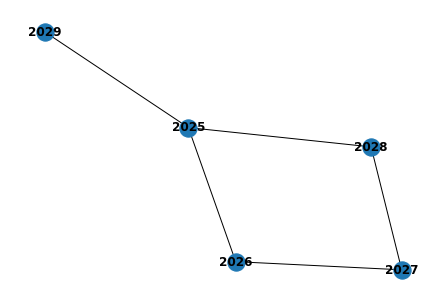

f1_score, ged 0.9090909090909091 1.0


Explain node 2028: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 542.21it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

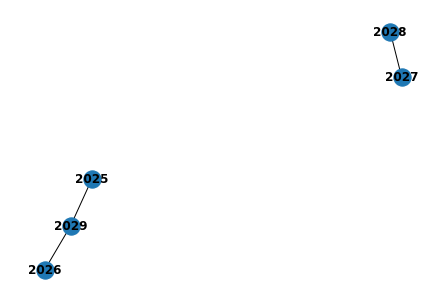

f1_score, ged 0.6666666666666666 3.0


Explain node 2029: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 375.40it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

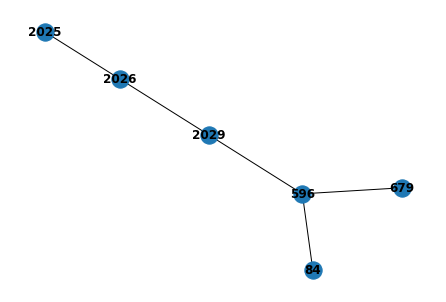

f1_score, ged 0.3636363636363636 4.0


Explain node 2030: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 476.62it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

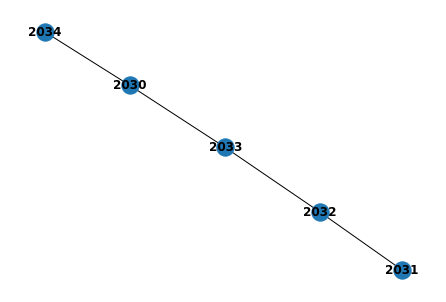

f1_score, ged 0.8 2.0


Explain node 2031: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 415.05it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

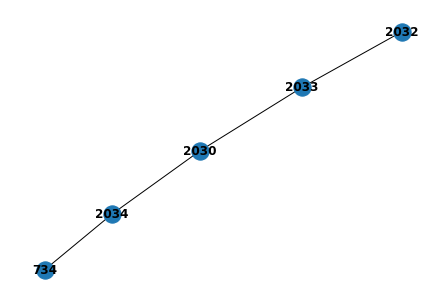

f1_score, ged 0.6 2.0


Explain node 2032: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 501.42it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

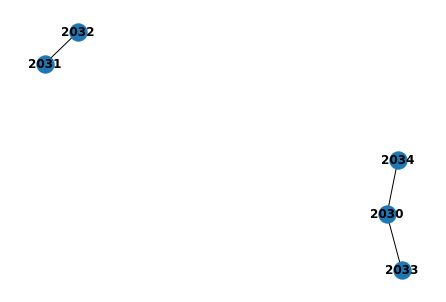

f1_score, ged 0.6666666666666666 3.0


Explain node 2033: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 546.62it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

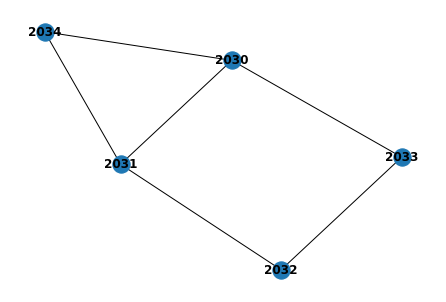

f1_score, ged 1.0 0.0


Explain node 2034: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 549.31it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

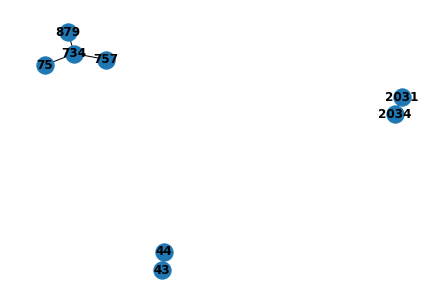

f1_score, ged 0.1818181818181818 8.0


Explain node 2035: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550.42it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

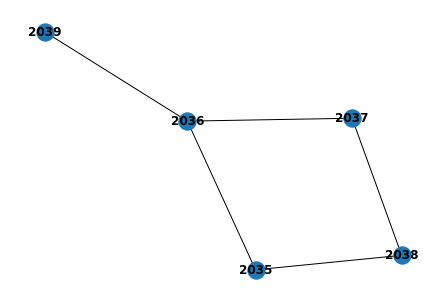

f1_score, ged 0.9090909090909091 1.0


Explain node 2036: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 526.39it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

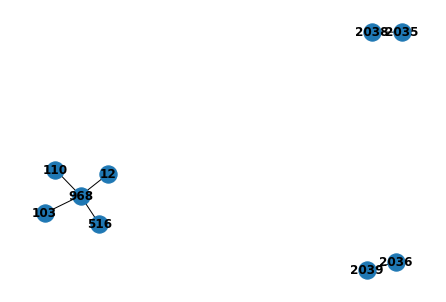

f1_score, ged 0.3333333333333333 10.0


Explain node 2037: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 423.99it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

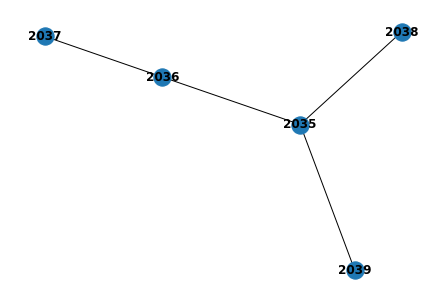

f1_score, ged 0.8 2.0


Explain node 2038: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.79it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

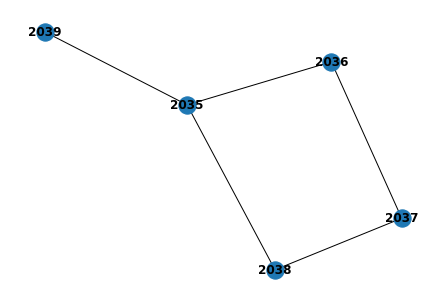

f1_score, ged 0.9090909090909091 1.0


Explain node 2039: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 463.99it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

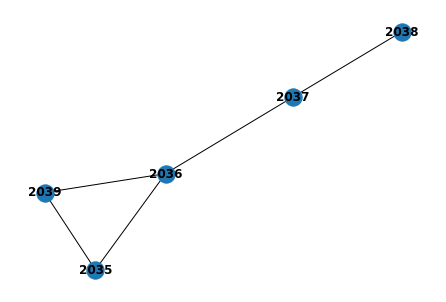

f1_score, ged 0.9090909090909091 1.0


Explain node 2040: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 511.86it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

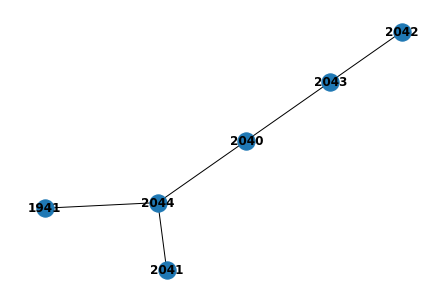

f1_score, ged 0.7272727272727272 4.0


Explain node 2041: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 471.99it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

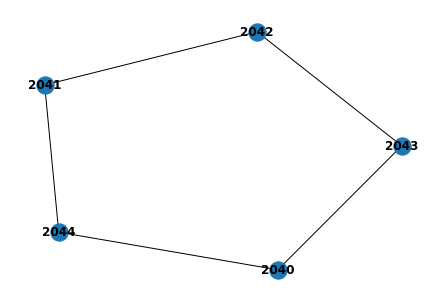

f1_score, ged 0.9090909090909091 1.0


Explain node 2042: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.06it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

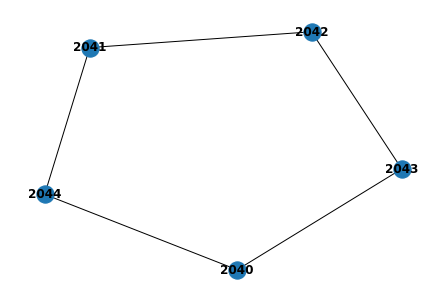

f1_score, ged 0.9090909090909091 1.0


Explain node 2043: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.70it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

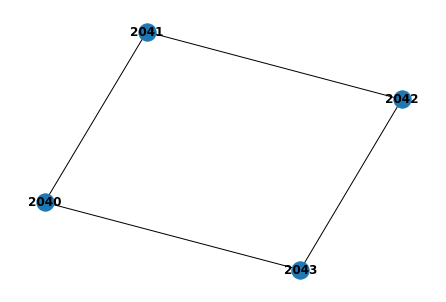

f1_score, ged 0.8 3.0


Explain node 2044: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 505.10it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

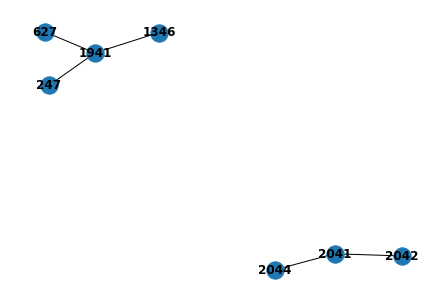

f1_score, ged 0.3636363636363636 7.0


Explain node 2045: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 499.41it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

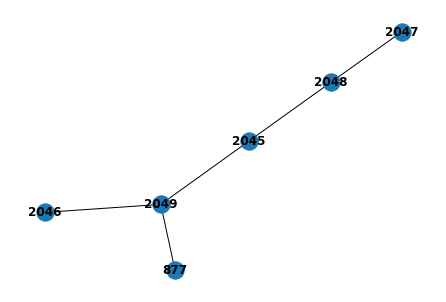

f1_score, ged 0.7272727272727272 4.0


Explain node 2046: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 443.01it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

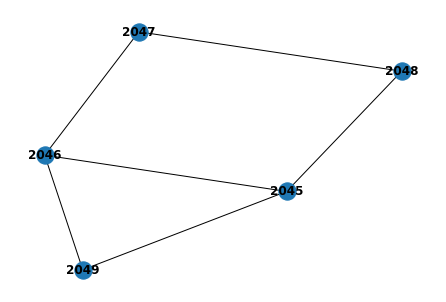

f1_score, ged 1.0 0.0


Explain node 2047: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 483.58it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

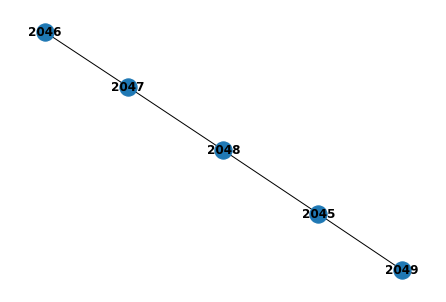

f1_score, ged 0.8 2.0


Explain node 2048: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 446.50it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

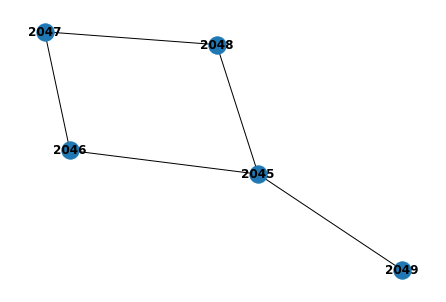

f1_score, ged 0.9090909090909091 1.0


Explain node 2049: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.83it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

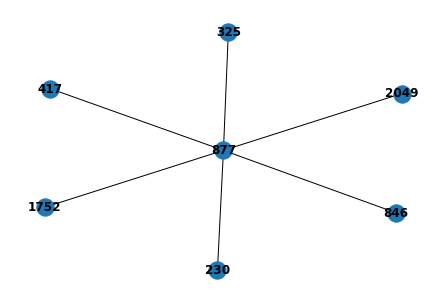

f1_score, ged 0 8.0


Explain node 2050: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.40it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

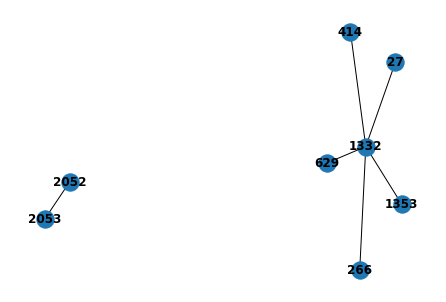

f1_score, ged 0.16666666666666666 9.0


Explain node 2051: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 488.44it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

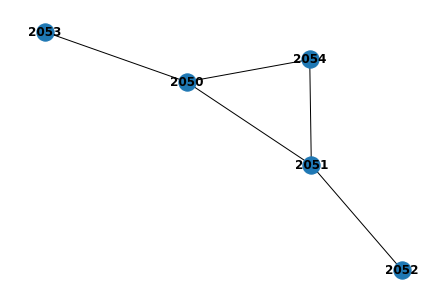

f1_score, ged 0.9090909090909091 1.0


Explain node 2052: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 484.97it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

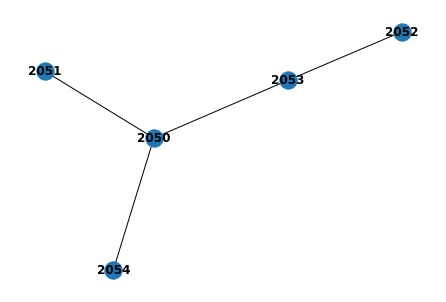

f1_score, ged 0.8 2.0


Explain node 2053: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 494.57it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

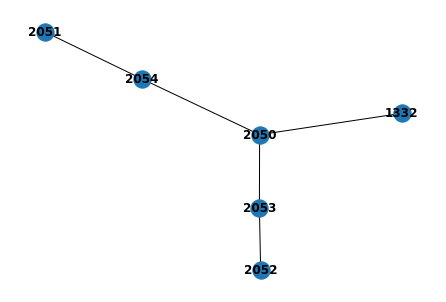

f1_score, ged 0.7272727272727272 4.0


Explain node 2054: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 453.41it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

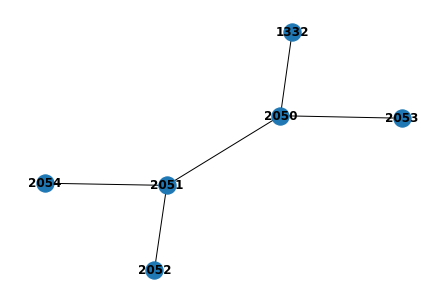

f1_score, ged 0.7272727272727272 4.0


Explain node 2055: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 477.23it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

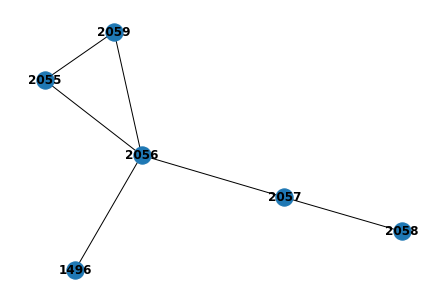

f1_score, ged 0.8333333333333334 3.0


Explain node 2056: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.77it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

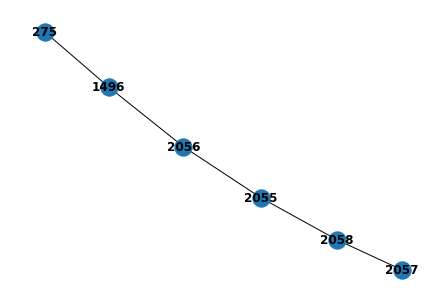

f1_score, ged 0.5454545454545454 4.0


Explain node 2057: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 530.08it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

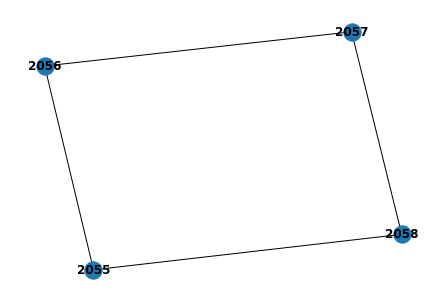

f1_score, ged 0.8 3.0


Explain node 2058: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.27it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

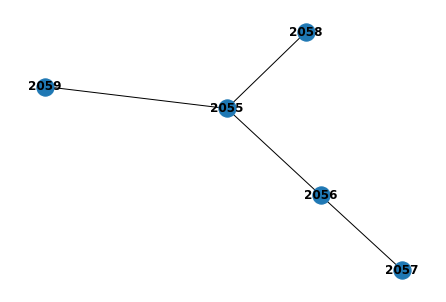

f1_score, ged 0.8 2.0


Explain node 2059: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 461.33it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

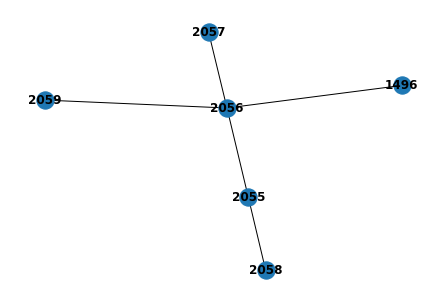

f1_score, ged 0.7272727272727272 4.0


Explain node 2060: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 475.01it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

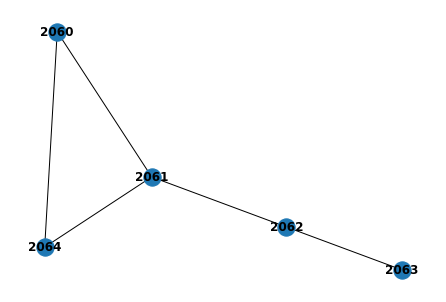

f1_score, ged 0.9090909090909091 1.0


Explain node 2061: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 458.68it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

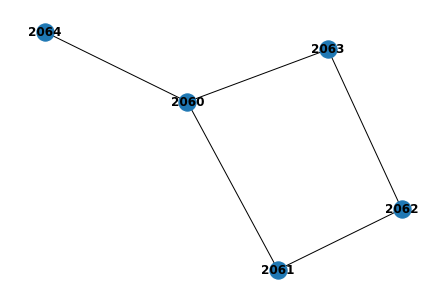

f1_score, ged 0.9090909090909091 1.0


Explain node 2062: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 470.50it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

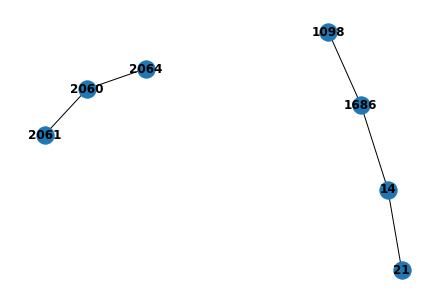

f1_score, ged 0.3636363636363636 7.0


Explain node 2063: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 507.05it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

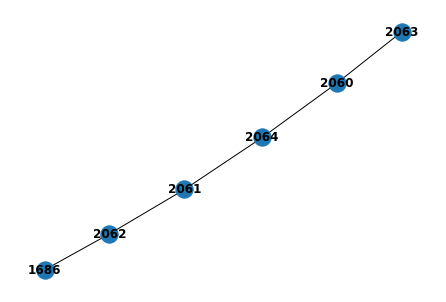

f1_score, ged 0.7272727272727272 4.0


Explain node 2064: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 515.46it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

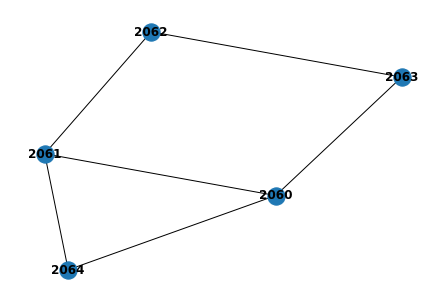

f1_score, ged 1.0 0.0


Explain node 2065: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 458.91it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

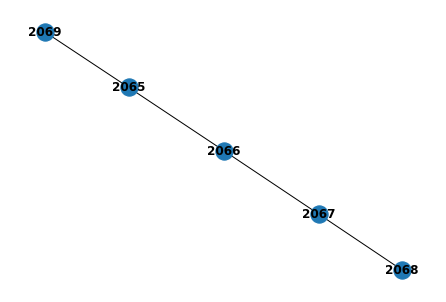

f1_score, ged 0.8 2.0


Explain node 2066: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.40it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

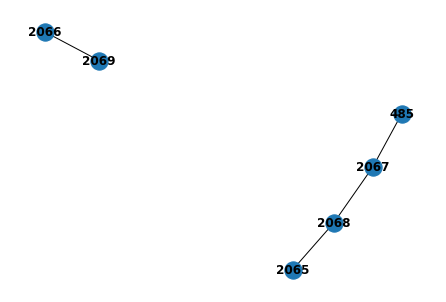

f1_score, ged 0.6 5.0


Explain node 2067: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 521.01it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

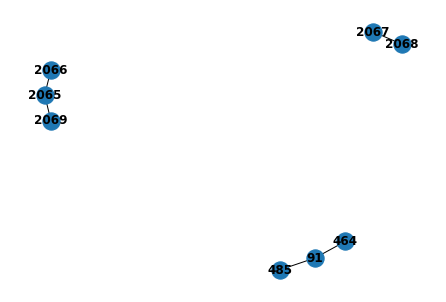

f1_score, ged 0.5454545454545454 8.0


Explain node 2068: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.28it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

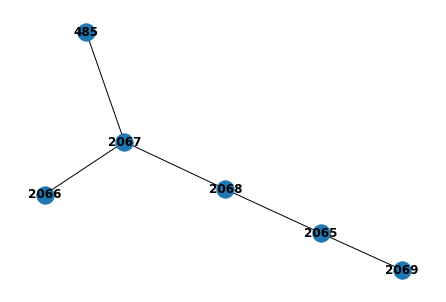

f1_score, ged 0.7272727272727272 4.0


Explain node 2069: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.00it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

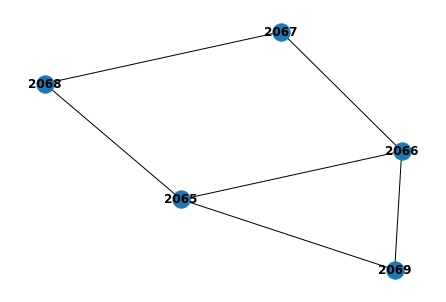

f1_score, ged 1.0 0.0


Explain node 2070: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 525.86it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

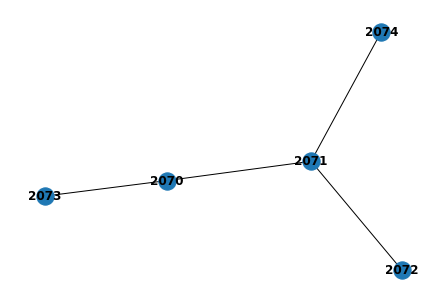

f1_score, ged 0.8 2.0


Explain node 2071: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 517.75it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

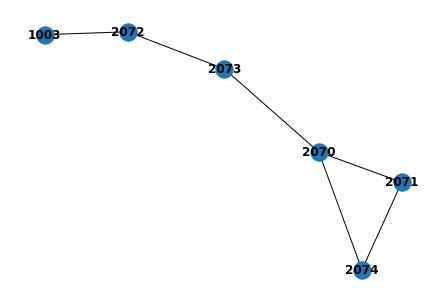

f1_score, ged 0.8333333333333334 3.0


Explain node 2072: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 557.43it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

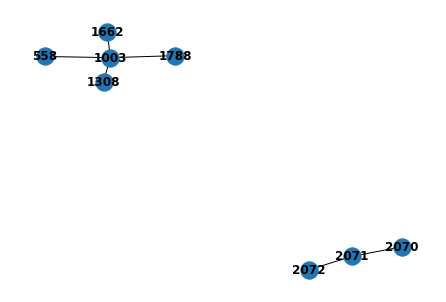

f1_score, ged 0.3333333333333333 9.0


Explain node 2073: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 563.16it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

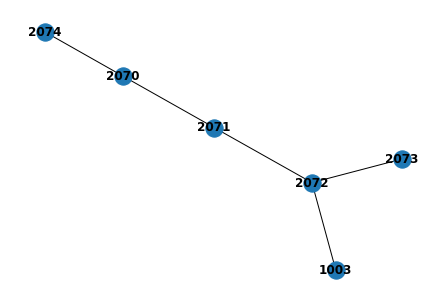

f1_score, ged 0.7272727272727272 4.0


Explain node 2074: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 457.31it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

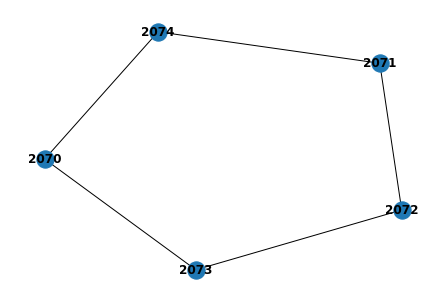

f1_score, ged 0.9090909090909091 1.0


Explain node 2075: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 442.30it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

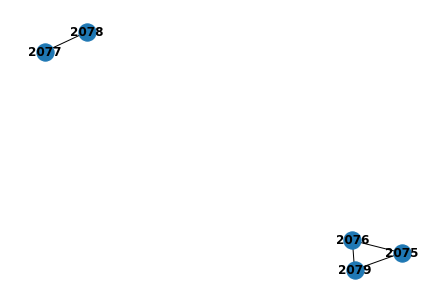

f1_score, ged 0.8 2.0


Explain node 2076: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 429.57it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

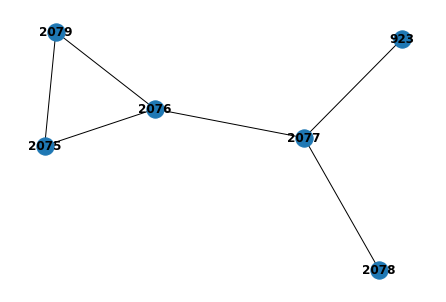

f1_score, ged 0.8333333333333334 3.0


Explain node 2077: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 538.87it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

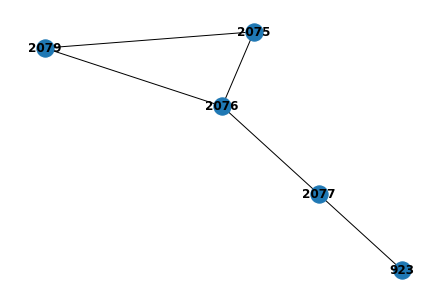

f1_score, ged 0.7272727272727272 1.0


Explain node 2078: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 518.95it/s]


zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

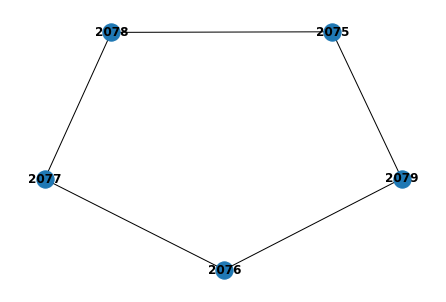

f1_score, ged 0.9090909090909091 1.0


Explain node 2079: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 472.13it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

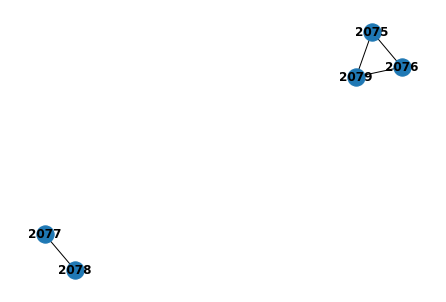

f1_score, ged 0.8 2.0


Explain node 2080: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 450.43it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

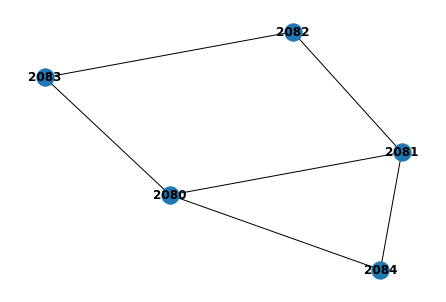

f1_score, ged 1.0 0.0


Explain node 2081: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 426.01it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

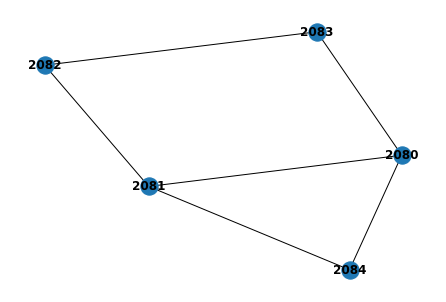

f1_score, ged 1.0 0.0


Explain node 2082: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 461.09it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

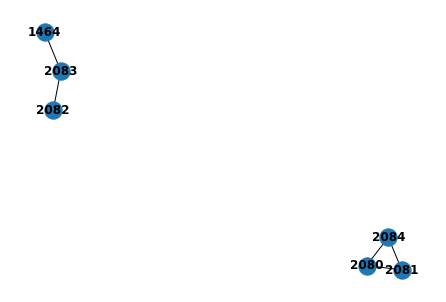

f1_score, ged 0.7272727272727272 4.0


Explain node 2083: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 489.42it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

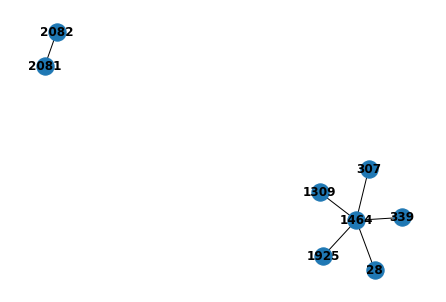

f1_score, ged 0.16666666666666666 9.0


Explain node 2084: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 491.47it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

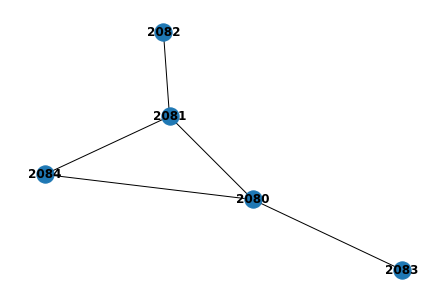

f1_score, ged 0.9090909090909091 1.0


Explain node 2085: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 482.61it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

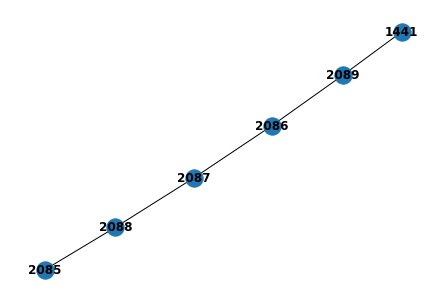

f1_score, ged 0.7272727272727272 4.0


Explain node 2086: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 483.23it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

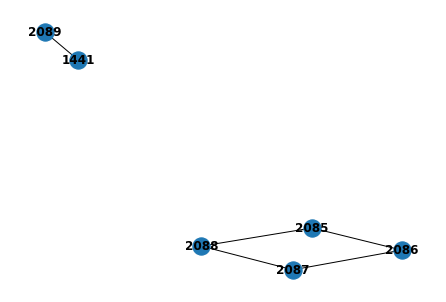

f1_score, ged 0.7272727272727272 4.0


Explain node 2087: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 493.35it/s]

zero_mask_prob [0.09784076 0.3882069  0.35776323 0.15618914]


<Figure size 432x288 with 0 Axes>

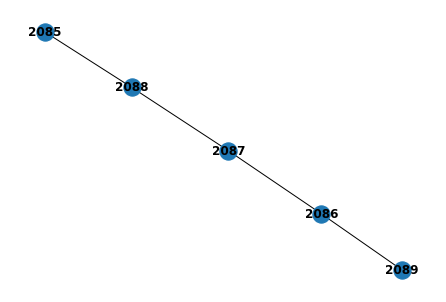

f1_score, ged 0.8 2.0


Explain node 2088:   0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [173]:
from torch_geometric.nn import GNNExplainer

list_node_idx = range(n_basis,n_basis+5*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
related_preds = []
AUC = []

explainer = GNNExplainer(model)
for node_idx in list_node_idx:
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    
    related_preds = add_related_pred(model, data, related_preds, edge_mask, node_idx)
    recall, precision, f1_score, ged, auc = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    AUC.append(auc)
    print("f1_score, ged", f1_score, ged)

In [175]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(AUC))


new_related_preds={}
for k,v in [(key,d[key]) for d in related_preds for key in d]:
  if k not in new_related_preds: new_related_preds[k]=np.array([v])
  else: np.append(new_related_preds[k], v)
    
print("fidelity+ (-->1): ", fidelity(new_related_preds))
print("fidelity- (-->0): ", fidelity_inv(new_related_preds))

fidelity+ (-->1):  0.012446016073226929
fidelity- (-->0):  -0.02485048770904541


In [204]:
from scipy.special import softmax

def add_related_pred(model, data, related_preds, edge_mask, node_idx, true_label=True):

    edge_mask = torch.Tensor(edge_mask)
    zero_mask = torch.zeros(edge_mask.size())

    ori_pred = model(data.x, data.edge_index)
    masked_pred = model(x=data.x, edge_index=data.edge_index, edge_weight=edge_mask)
    maskout_pred = model(x=data.x, edge_index=data.edge_index, edge_weight=1-edge_mask)
    zero_mask_pred = model(x=data.x, edge_index=data.edge_index, edge_weight=zero_mask)

    ori_prob = softmax(ori_pred[node_idx].detach().numpy())
    masked_prob = softmax(masked_pred[node_idx].detach().numpy())
    maskout_prob = softmax(maskout_pred[node_idx].detach().numpy())
    zero_mask_prob = softmax(zero_mask_pred[node_idx].detach().numpy())
    print("zero_mask_prob", zero_mask_prob)
    
    if true_label: 
        label = data.y[node_idx].detach().numpy()
    else: 
        label = np.argmax(ori_prob)
    print("true label", data.y[node_idx].detach().numpy())
    print("predicted label", np.argmax(ori_prob))
    print(masked_prob[data.y[node_idx].detach().numpy()])
    print(masked_prob[np.argmax(ori_prob)])

    related_preds.append({'zero': zero_mask_prob[label],
                                  'masked': masked_prob[label],
                                  'maskout': maskout_prob[label],
                                  'origin': ori_prob[label]})
    return related_preds

# Fidelity+  metric  studies  the  prediction  change  by
# removing  important  nodes/edges/node  features. 
# Higher fidelity+ value indicates good explanations 
def fidelity(related_preds):
    ori_probs = related_preds['origin']
    unimportant_probs = related_preds['maskout']
    drop_probability = ori_probs - unimportant_probs
    return drop_probability.mean().item()

# Fidelity-  metric  studies  the  prediction  change  by
# removing  unimportant  nodes/edges/node  features. 
# Lower fidelity- value indicates good explanations 
def fidelity_inv(related_preds):
    ori_probs = related_preds['origin']
    important_probs = related_preds['masked']
    drop_probability = ori_probs - important_probs
    return drop_probability.mean().item()
    
    

In [51]:
threshold = 0.1
masked_edge_index = data.edge_index[:,edge_mask>threshold]
maskout_edge_index = data.edge_index[:,1-edge_mask>threshold]

pred = model(data.x, data.edge_index)
masked_pred = model(data.x, masked_edge_index)
maskout_pred = model(data.x, maskout_edge_index)

label = data.y[node_idx].detach().numpy()

masked_prob = softmax(masked_pred[node_idx].detach().numpy())
maskout_prob = softmax(maskout_pred[node_idx].detach().numpy())
prob = softmax(pred[node_idx].detach().numpy())

torch.Size([2, 1100])

In [148]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [149]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [150]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [151]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

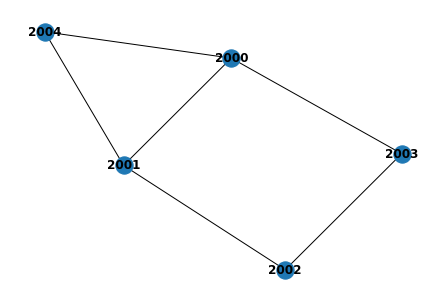

ValueError: too many values to unpack (expected 4)

<Figure size 432x288 with 0 Axes>

In [197]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, target = labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    #print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [29]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.22946859903381642 7.521739130434782 0.22946859903381642 0.22946859903381642


In [185]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


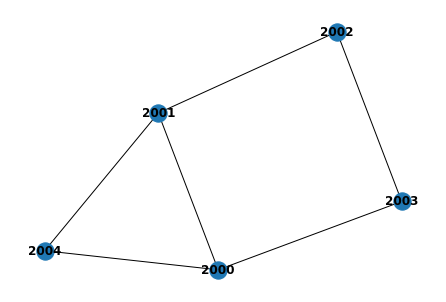

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42915523
0.42915523
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42915523
0.42915523


<Figure size 432x288 with 0 Axes>

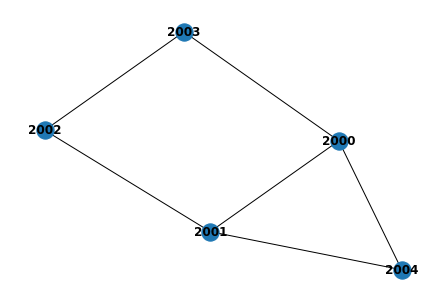

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

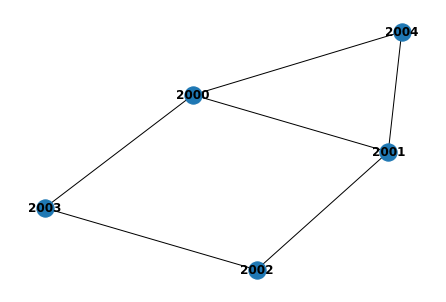

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

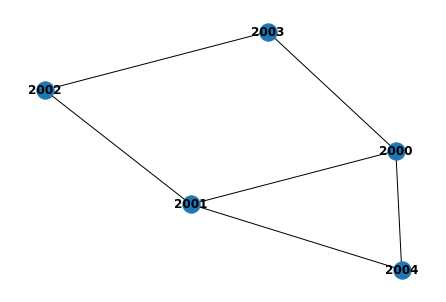

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.111392476
0.39368522
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.111392476
0.39368522


<Figure size 432x288 with 0 Axes>

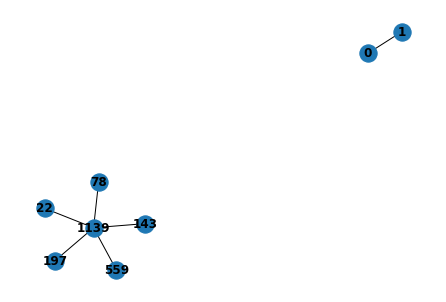

f1_score, ged 0 9.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

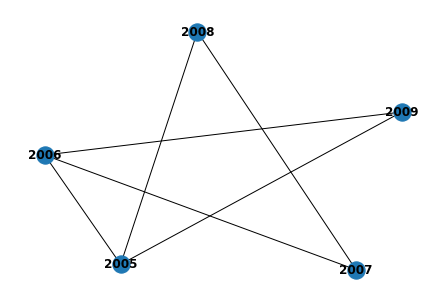

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3310243
0.3310243
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3310243
0.3310243


<Figure size 432x288 with 0 Axes>

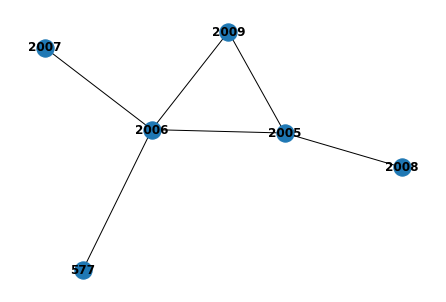

f1_score, ged 0.8333333333333334 3.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.2704344
0.36429164
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.2704344
0.36429164


<Figure size 432x288 with 0 Axes>

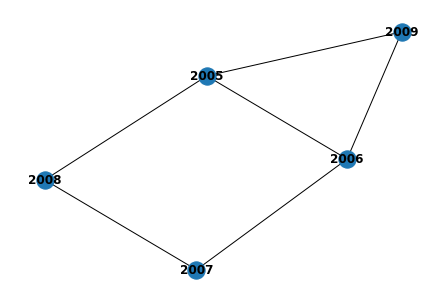

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575


<Figure size 432x288 with 0 Axes>

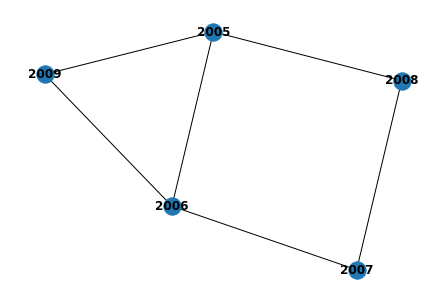

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11475305
0.24189271
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11475305
0.24189271


<Figure size 432x288 with 0 Axes>

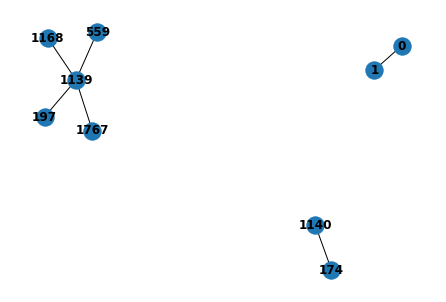

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

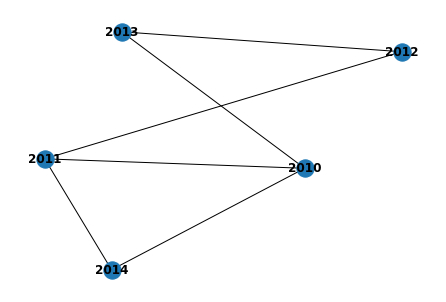

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42890328
0.42890328
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42890328
0.42890328


<Figure size 432x288 with 0 Axes>

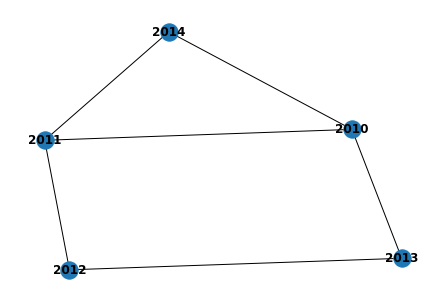

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

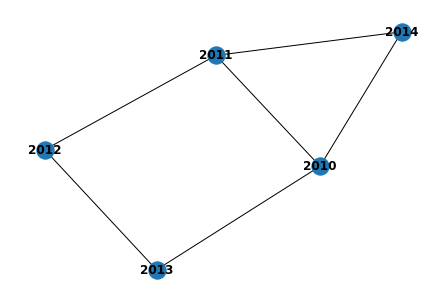

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

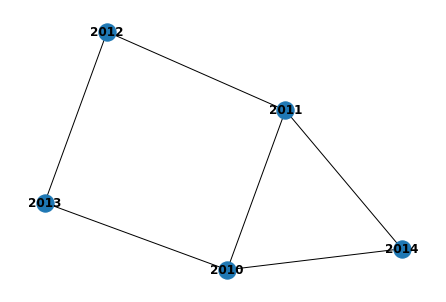

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.11197232
0.39040485
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.11197232
0.39040485


<Figure size 432x288 with 0 Axes>

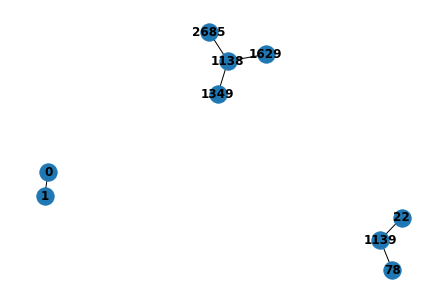

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

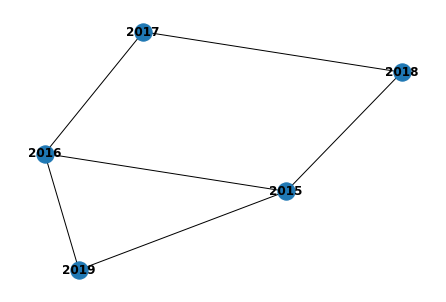

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4134166
0.4134166
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4134166
0.4134166


<Figure size 432x288 with 0 Axes>

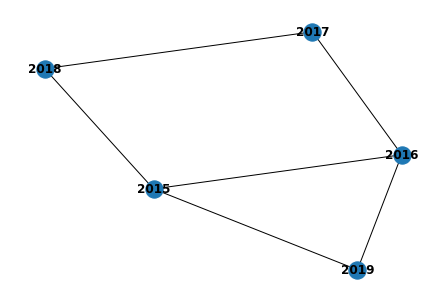

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27020743
0.36575773
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27020743
0.36575773


<Figure size 432x288 with 0 Axes>

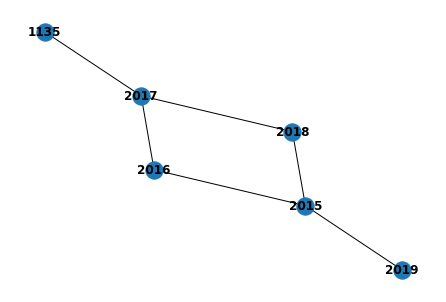

f1_score, ged 0.8333333333333334 3.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26959714
0.3696299
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26959714
0.3696299


<Figure size 432x288 with 0 Axes>

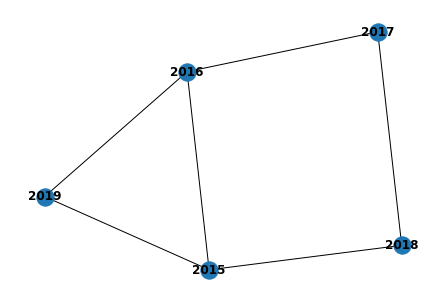

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.112959646
0.38480106
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.112959646
0.38480106


<Figure size 432x288 with 0 Axes>

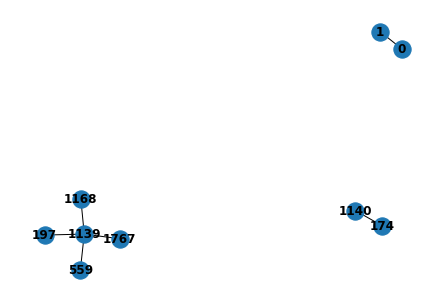

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

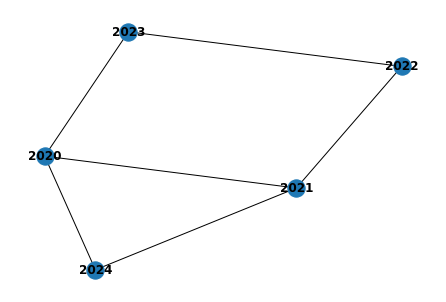

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3558872
0.3558872
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.3558872
0.3558872


<Figure size 432x288 with 0 Axes>

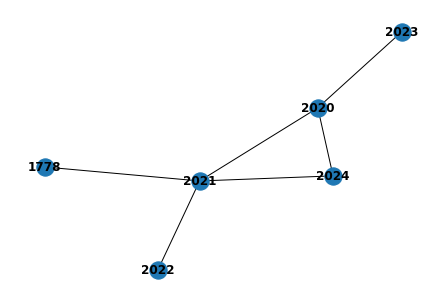

f1_score, ged 0.8333333333333334 3.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 0
0.27038136
0.24849957
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 0
0.27038136
0.24849957


<Figure size 432x288 with 0 Axes>

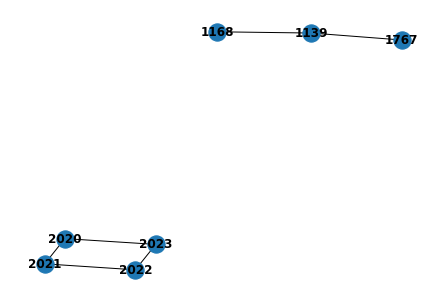

f1_score, ged 0.6666666666666666 6.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575


<Figure size 432x288 with 0 Axes>

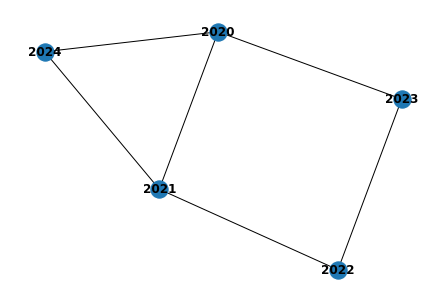

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11365052
0.23776485
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11365052
0.23776485


<Figure size 432x288 with 0 Axes>

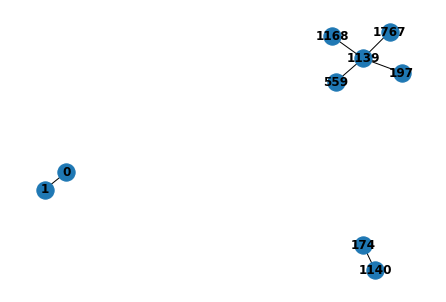

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

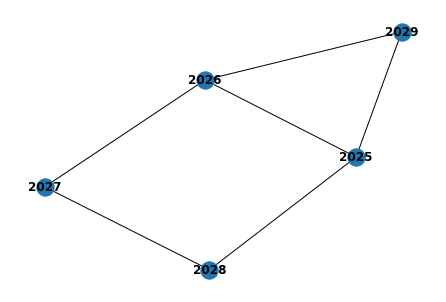

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4280127
0.4280127
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4280127
0.4280127


<Figure size 432x288 with 0 Axes>

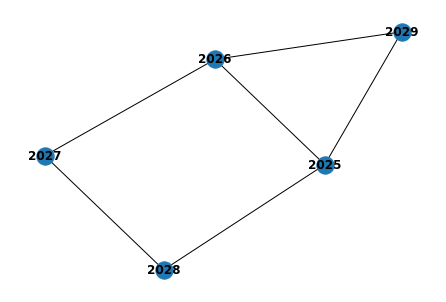

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

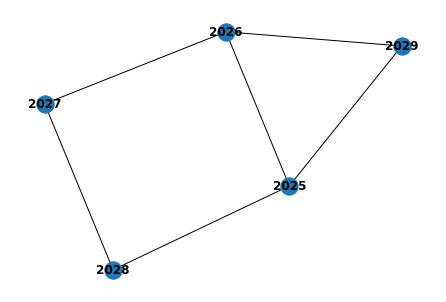

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

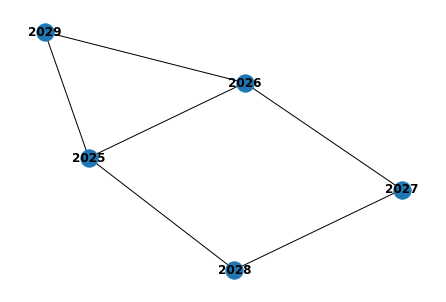

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.110687636
0.22698306
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.110687636
0.22698306


<Figure size 432x288 with 0 Axes>

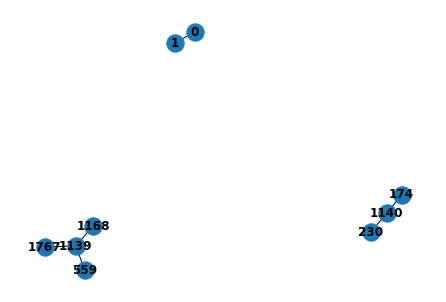

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

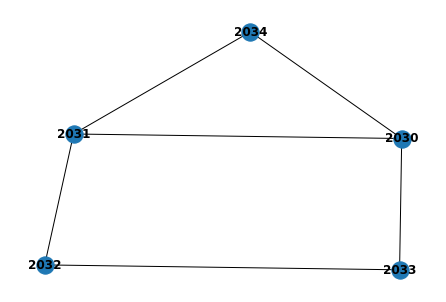

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42851877
0.42851877
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42851877
0.42851877


<Figure size 432x288 with 0 Axes>

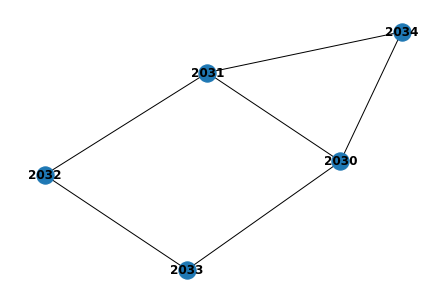

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

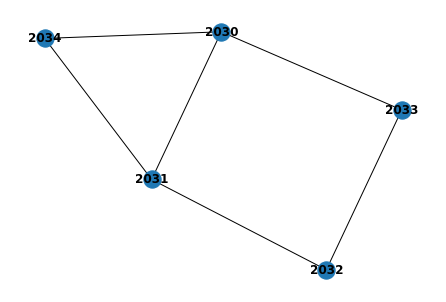

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

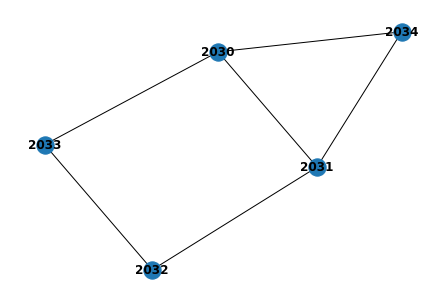

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11313576
0.23585813
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11313576
0.23585813


<Figure size 432x288 with 0 Axes>

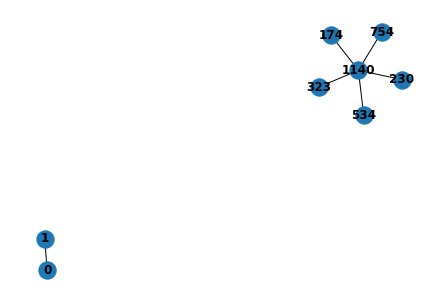

f1_score, ged 0 9.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

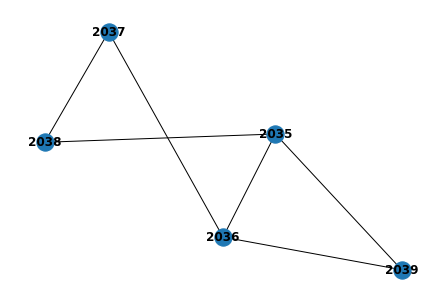

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32757202
0.32757202
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.32757202
0.32757202


<Figure size 432x288 with 0 Axes>

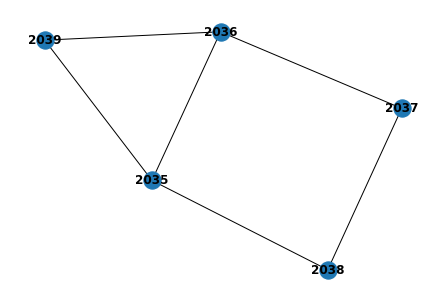

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27043244
0.36430436
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27043244
0.36430436


<Figure size 432x288 with 0 Axes>

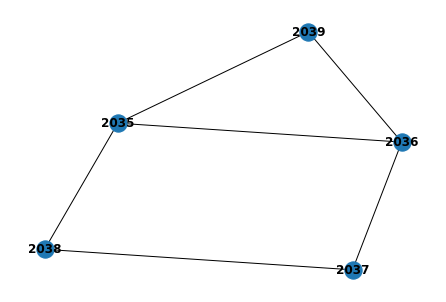

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26963943
0.36936575


<Figure size 432x288 with 0 Axes>

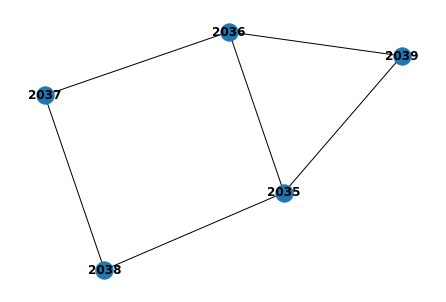

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11477456
0.24197374
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11477456
0.24197374


<Figure size 432x288 with 0 Axes>

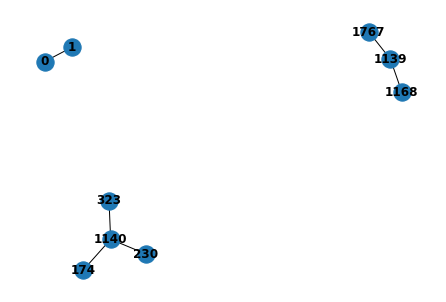

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

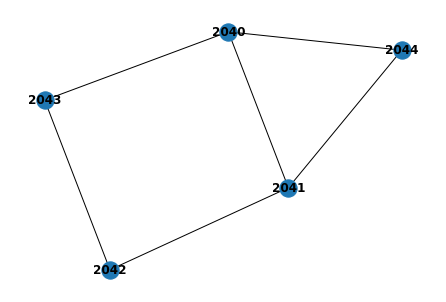

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42915523
0.42915523
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42915523
0.42915523


<Figure size 432x288 with 0 Axes>

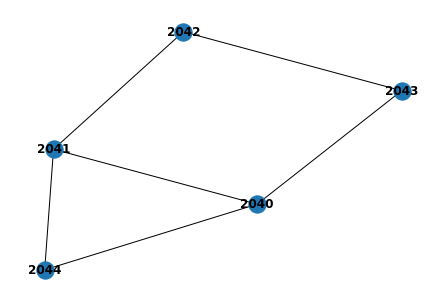

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

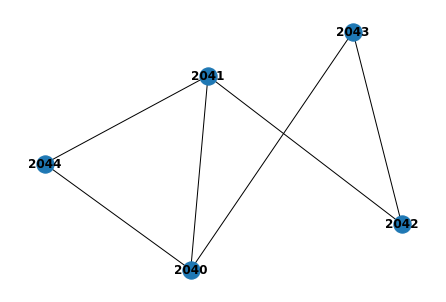

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

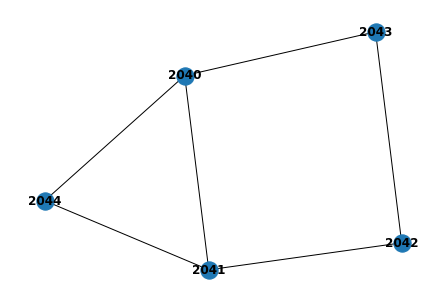

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.11119683
0.39479065
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 1
0.11119683
0.39479065


<Figure size 432x288 with 0 Axes>

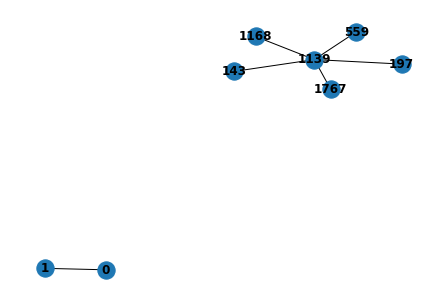

f1_score, ged 0 9.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36441252
0.36441252


<Figure size 432x288 with 0 Axes>

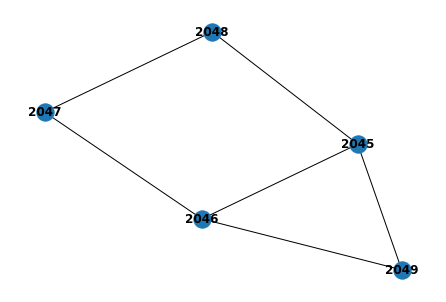

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42823377
0.42823377
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.42823377
0.42823377


<Figure size 432x288 with 0 Axes>

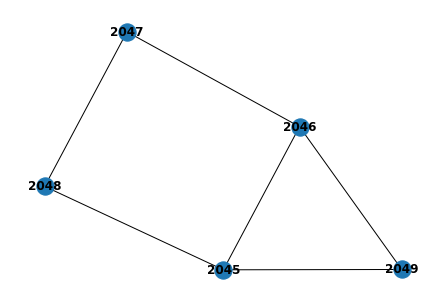

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27034938
0.3648435


<Figure size 432x288 with 0 Axes>

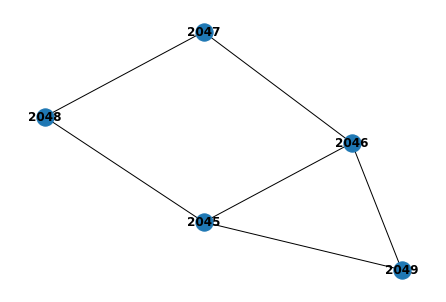

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.26967117
0.36916596


<Figure size 432x288 with 0 Axes>

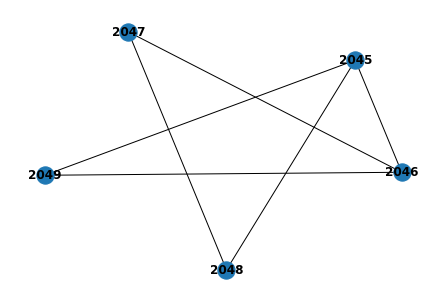

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11219522
0.23241271
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 3
predicted label 0
0.11219522
0.23241271


<Figure size 432x288 with 0 Axes>

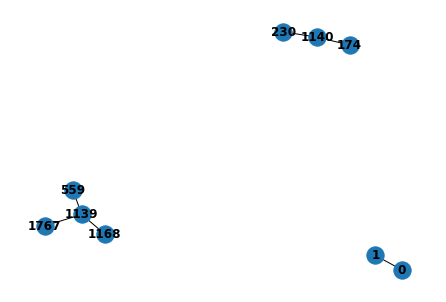

f1_score, ged 0 10.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36764872
0.36764872
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.36764872
0.36764872


<Figure size 432x288 with 0 Axes>

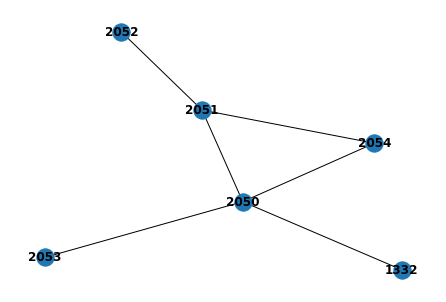

f1_score, ged 0.8333333333333334 3.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4075614
0.4075614
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 1
predicted label 1
0.4075614
0.4075614


<Figure size 432x288 with 0 Axes>

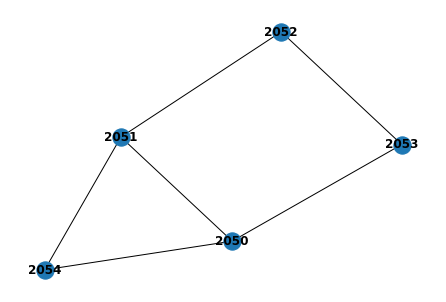

f1_score, ged 1.0 0.0
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27033973
0.36490604
zero_mask_prob [0.24865082 0.36441252 0.27041614 0.11652058]
true label 2
predicted label 1
0.27033973
0.36490604


<Figure size 432x288 with 0 Axes>

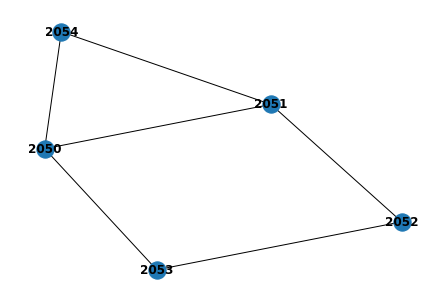

f1_score, ged 1.0 0.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [205]:
list_node_idx = range(n_basis,n_basis+200)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
AUC = []
true_related_preds = []
pred_related_preds = []

for node_idx in list_node_idx:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    #print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    true_related_preds = add_related_pred(model, data, true_related_preds, edge_mask, node_idx, true_label=True)
    pred_related_preds = add_related_pred(model, data, pred_related_preds, edge_mask, node_idx, true_label=False)
    recall, precision, f1_score, ged, auc = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    #print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    AUC.append(auc)
    print("f1_score, ged", f1_score, ged)

In [206]:
pred_related_preds

[{'zero': 0.36441252,
  'masked': 0.36441252,
  'maskout': 0.35366938,
  'origin': 0.38768443},
 {'zero': 0.36441252,
  'masked': 0.42915523,
  'maskout': 0.37613732,
  'origin': 0.38768443},
 {'zero': 0.36441252,
  'masked': 0.3648435,
  'maskout': 0.3290322,
  'origin': 0.32755834},
 {'zero': 0.36441252,
  'masked': 0.36916596,
  'maskout': 0.3220546,
  'origin': 0.32755834},
 {'zero': 0.36441252,
  'masked': 0.39368522,
  'maskout': 0.3256601,
  'origin': 0.31589323},
 {'zero': 0.36441252,
  'masked': 0.36441252,
  'maskout': 0.24680103,
  'origin': 0.39390692},
 {'zero': 0.36441252,
  'masked': 0.3310243,
  'maskout': 0.3285749,
  'origin': 0.40897843},
 {'zero': 0.36441252,
  'masked': 0.36429164,
  'maskout': 0.31126228,
  'origin': 0.30848092},
 {'zero': 0.36441252,
  'masked': 0.36936575,
  'maskout': 0.31978416,
  'origin': 0.3251407},
 {'zero': 0.24865082,
  'masked': 0.24189271,
  'maskout': 0.3016214,
  'origin': 0.30609825},
 {'zero': 0.36441252,
  'masked': 0.36441252,
  

In [207]:
true_related_preds

[{'zero': 0.36441252,
  'masked': 0.36441252,
  'maskout': 0.35366938,
  'origin': 0.38768443},
 {'zero': 0.36441252,
  'masked': 0.42915523,
  'maskout': 0.37613732,
  'origin': 0.38768443},
 {'zero': 0.27041614,
  'masked': 0.27034938,
  'maskout': 0.27508897,
  'origin': 0.2752314},
 {'zero': 0.27041614,
  'masked': 0.26967117,
  'maskout': 0.27578816,
  'origin': 0.2752314},
 {'zero': 0.11652058,
  'masked': 0.111392476,
  'maskout': 0.12316549,
  'origin': 0.12481205},
 {'zero': 0.36441252,
  'masked': 0.36441252,
  'maskout': 0.24680103,
  'origin': 0.39390692},
 {'zero': 0.36441252,
  'masked': 0.3310243,
  'maskout': 0.3285749,
  'origin': 0.40897843},
 {'zero': 0.27041614,
  'masked': 0.2704344,
  'maskout': 0.27678272,
  'origin': 0.27699336},
 {'zero': 0.27041614,
  'masked': 0.26963943,
  'maskout': 0.27604544,
  'origin': 0.27552485},
 {'zero': 0.11652058,
  'masked': 0.11475305,
  'maskout': 0.12891124,
  'origin': 0.12982851},
 {'zero': 0.36441252,
  'masked': 0.36441252

In [224]:
pred_dict=pd.DataFrame(pred_related_preds).to_dict('list')
for key in pred_dict.keys():
    pred_dict[key] = np.array(pred_dict[key])

true_pred_dict=pd.DataFrame(true_related_preds).to_dict('list')
for key in true_pred_dict.keys():
    true_pred_dict[key] = np.array(true_pred_dict[key])

In [225]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(AUC))


print("fidelity+ (-->1) with true labels: ", fidelity(true_pred_dict))
print("fidelity- (-->0) with true labels: ", fidelity_inv(true_pred_dict))


print("fidelity+ (-->1) with predicted labels: ", fidelity(pred_dict))
print("fidelity- (-->0) with predicted labels: ", fidelity_inv(pred_dict))

0.7924528301886794 2.169811320754717 0.7924528301886794 0.7924528301886794 0.6524699461351097
fidelity+ (-->1) with true labels:  0.025999337575345668
fidelity- (-->0) with true labels:  0.007775120577722226
fidelity+ (-->1) with predicted labels:  0.026860216878495127
fidelity- (-->0) with predicted labels:  -0.0041743764337503686


In [32]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


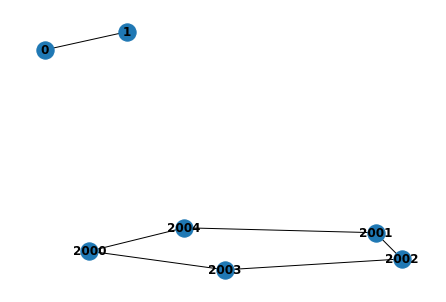

tensor([[2000, 2001, 2001, 2002, 2000,    0],
        [2004, 2004, 2002, 2003, 2003,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

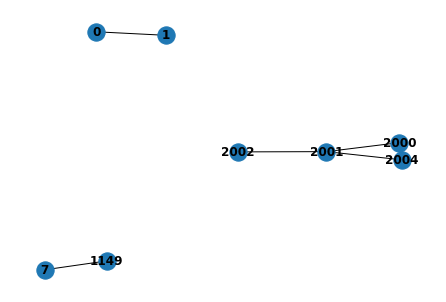

tensor([[2000, 2001, 2001, 2000,    0, 1149],
        [2004, 2004, 2002, 2001,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

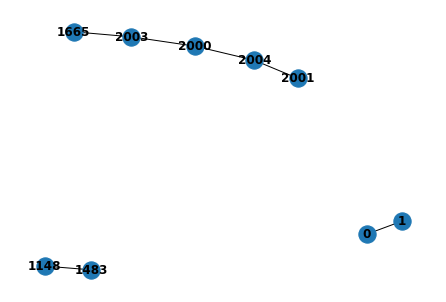

tensor([[2000, 2001, 1665, 2000,    0, 1148],
        [2004, 2004, 2003, 2003,    1, 1483]])
f1_score, ged 0.5 8.0
[1.67100430e-02 9.87148285e-03 2.71797180e-05 1.99079514e-04
 1.48463249e-03 1.48463249e-03 1.48463249e-03 6.90361261e-02
 5.58915138e-02 1.61062956e-01 9.20534134e-03 2.72258520e-02
 1.61062956e-01 5.58915138e-02 2.18153000e-04 9.20534134e-03
 2.72258520e-02 5.58915138e-02]


<Figure size 432x288 with 0 Axes>

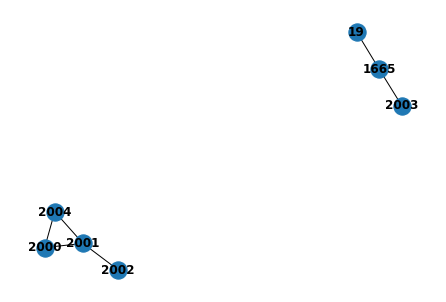

tensor([[2000, 2001, 1665, 2000, 2001,   19],
        [2004, 2004, 2003, 2001, 2002, 1665]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

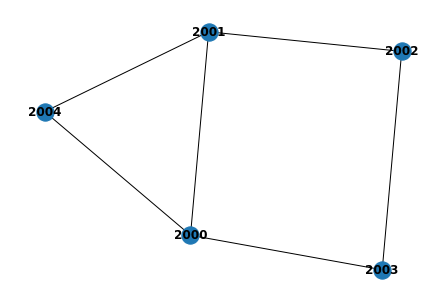

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2004, 2002, 2004, 2001, 2003, 2003]])
f1_score, ged 1.0 0.0
[0.01549125 0.4204604  0.17534226 0.18984991 0.4204604  0.05009085
 0.34293252 0.18984991 0.4264254 ]


<Figure size 432x288 with 0 Axes>

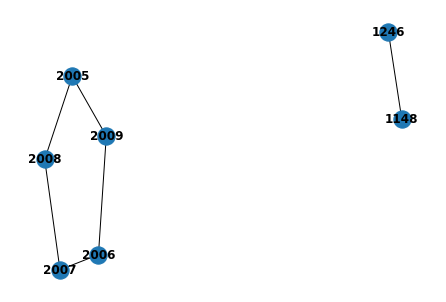

tensor([[2006, 2005, 2006, 2007, 2005, 1148],
        [2009, 2009, 2007, 2008, 2008, 1246]])
f1_score, ged 0.8333333333333334 4.0
[0.12051469 0.41694516 0.07163423 0.1895954  0.41694516 0.18146259
 0.07163423 0.1895954  0.10912126 0.18146259]


<Figure size 432x288 with 0 Axes>

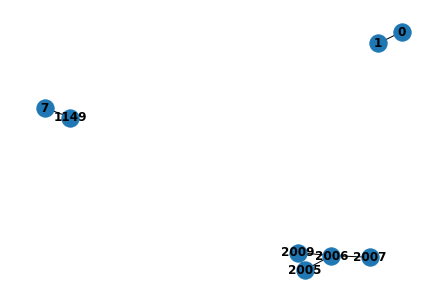

tensor([[2006, 2005, 2006, 2005,    0, 1149],
        [2009, 2009, 2007, 2006,    1,    7]])
f1_score, ged 0.6666666666666666 7.0
[0.02603137 0.00718439 0.46472955 0.23338819 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

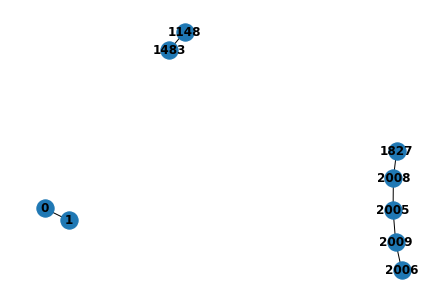

tensor([[2006, 2005, 1827, 2005,    0, 1148],
        [2009, 2009, 2008, 2008,    1, 1483]])
f1_score, ged 0.5 8.0
[0.01272047 0.00222707 0.00063252 0.00063252 0.00029409 0.00203836
 0.00135851 0.00164139 0.00164139 0.05118978 0.05576301 0.154006
 0.01026452 0.03008842 0.154006   0.05576301 0.01026452 0.03008842
 0.05576301]


<Figure size 432x288 with 0 Axes>

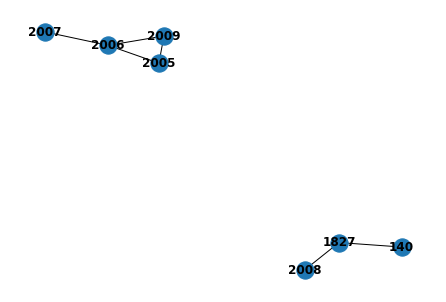

tensor([[2006, 2005, 2005, 1827, 2006,  140],
        [2009, 2009, 2006, 2008, 2007, 1827]])
f1_score, ged 0.6666666666666666 6.0
[0.03252065 0.02846277 0.49933362 0.14103723 0.2866776  0.103526
 0.02269602 0.02846277 0.14103723 0.2866776  0.14032996 0.02269602]


<Figure size 432x288 with 0 Axes>

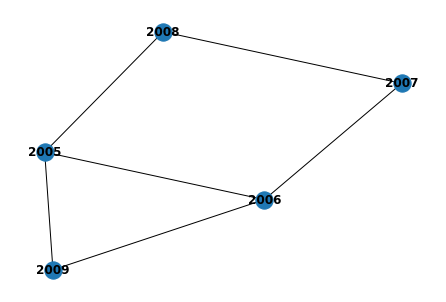

tensor([[2005, 2006, 2006, 2005, 2007, 2005],
        [2009, 2007, 2009, 2006, 2008, 2008]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

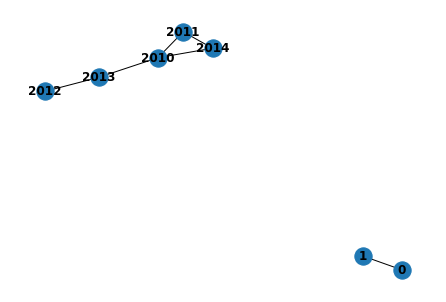

tensor([[2010, 2011, 2010, 2012, 2010,    0],
        [2014, 2014, 2013, 2013, 2011,    1]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

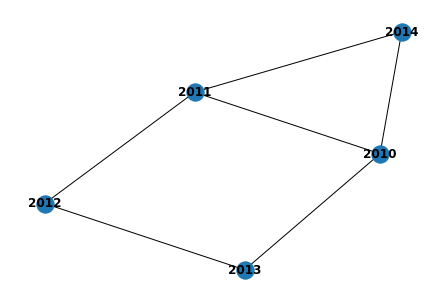

tensor([[2010, 2011, 2010, 2012, 2010, 2011],
        [2014, 2014, 2013, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[1.03420019e-02 9.20665264e-03 2.82919407e-03 7.63416290e-04
 9.97781754e-05 1.35302544e-04 5.19633293e-04 7.36594200e-04
 1.16193295e-03 7.75719881e-02 8.66246223e-03 2.57548094e-02
 1.64820671e-01 5.59939146e-02 1.64820671e-01 8.66246223e-03
 2.57548094e-02 5.59939146e-02 5.59473038e-03 5.59939146e-02]


<Figure size 432x288 with 0 Axes>

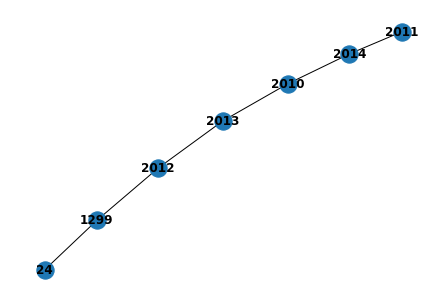

tensor([[2011, 2010, 1299, 2012, 2010,   24],
        [2014, 2014, 2012, 2013, 2013, 1299]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

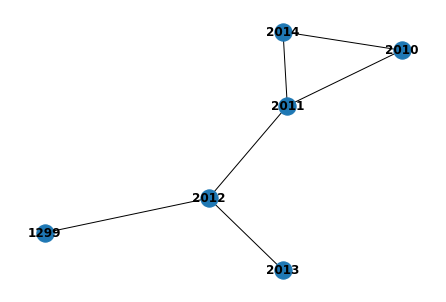

tensor([[2012, 2010, 2011, 2010, 1299, 2011],
        [2013, 2014, 2014, 2011, 2012, 2012]])
f1_score, ged 0.8333333333333334 3.0
[0.14103723 0.2866776  0.103526   0.03252065 0.02846277 0.49933362
 0.14103723 0.2866776  0.02269602 0.02846277 0.02269602 0.14032996]


<Figure size 432x288 with 0 Axes>

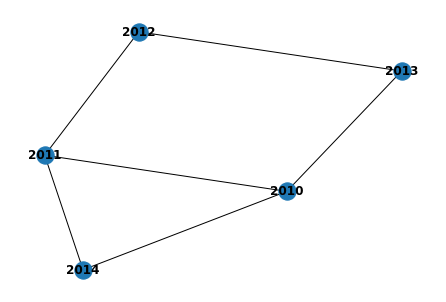

tensor([[2011, 2010, 2012, 2010, 2010, 2011],
        [2014, 2013, 2013, 2011, 2014, 2012]])
f1_score, ged 1.0 0.0
[0.07163423 0.1895954  0.41694516 0.12051469 0.41694516 0.07163423
 0.1895954  0.18146259 0.18146259 0.10912126]


<Figure size 432x288 with 0 Axes>

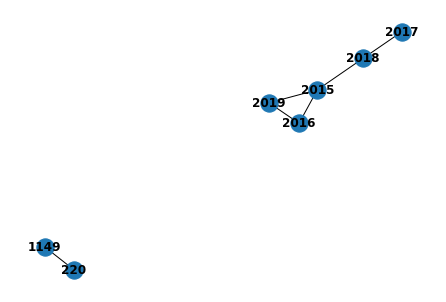

tensor([[2016, 2015, 2015, 2017, 2015, 1149],
        [2019, 2019, 2018, 2018, 2016,  220]])
f1_score, ged 0.8333333333333334 4.0
[0.17534226 0.18984991 0.4204604  0.01549125 0.4204604  0.34293252
 0.18984991 0.05009085 0.4264254 ]


<Figure size 432x288 with 0 Axes>

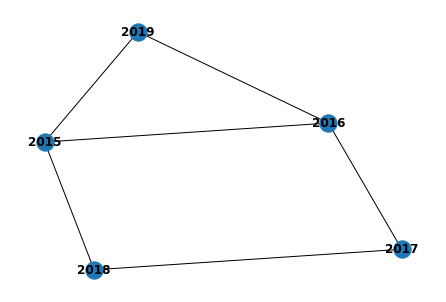

tensor([[2015, 2016, 2015, 2017, 2015, 2016],
        [2019, 2019, 2018, 2018, 2016, 2017]])
f1_score, ged 1.0 0.0
[1.22464895e-02 4.41122055e-03 7.96675682e-04 5.62334061e-03
 5.66244125e-05 3.92079353e-04 1.16348267e-03 7.37428665e-04
 3.09109688e-04 7.73830414e-02 8.67474079e-03 2.57881880e-02
 1.64734364e-01 5.59912920e-02 1.64734364e-01 8.67474079e-03
 2.57881880e-02 5.59912920e-02 5.47087193e-03 5.59912920e-02]


<Figure size 432x288 with 0 Axes>

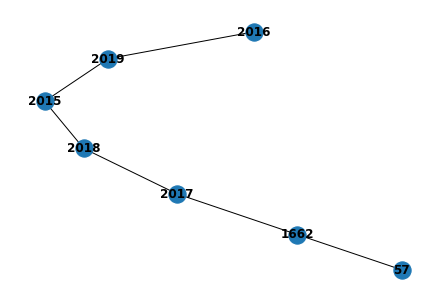

tensor([[2015, 2016, 1662, 2015, 2017,   57],
        [2019, 2019, 2017, 2018, 2018, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.02603137 0.23338819 0.46472955 0.00718439 0.46472955 0.00308192
 0.23338819 0.7114867  0.23338819]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [33]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [144]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.8166666666666668 3.55 0.8166666666666668 0.8166666666666668


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [35]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[0.51875682 0.51875682 0.51875682 0.51875682 0.51875682 0.51875682
 0.51875682 0.51875682 0.51875682 0.51875682 1.51875682 2.
 2.         1.99999999 2.         2.         1.99999999 2.
 2.         1.51875682 2.         2.         1.99999999 1.99999999]


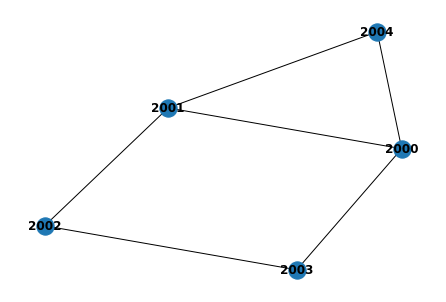

tensor([[2002, 2000, 2000, 2001, 2000, 2001],
        [2003, 2001, 2003, 2002, 2004, 2004]])
f1_score, ged 1.0 0.0
[0.49364384 1.0320932  0.52573704 0.55257066 1.0320932  1.52047746
 1.52047746 1.52047746 1.0141213  0.49364384 0.52573704 1.0141213
 0.55257066 1.52047746]


<Figure size 432x288 with 0 Axes>

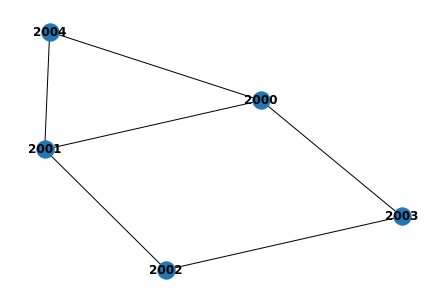

tensor([[2001, 2001, 2000, 2002, 2000, 2000],
        [2002, 2004, 2001, 2003, 2004, 2003]])
f1_score, ged 1.0 0.0
[0.045138   0.045138   0.045138   0.045138   0.045138   0.045138
 0.045138   0.045138   0.045138   0.045138   0.27226293 0.13793456
 0.22712493 0.35943989 0.13793456 1.13793456 0.49737445 1.13793456
 1.22712493 0.27226293 0.22712493 1.22712493 0.35943989 0.49737445]


<Figure size 432x288 with 0 Axes>

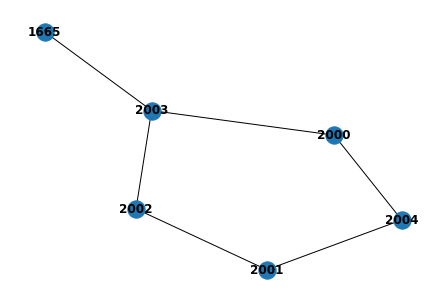

tensor([[2002, 2001, 2001, 2000, 1665, 2000],
        [2003, 2002, 2004, 2004, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.5786205  0.5786205  0.17502635 0.17502635 0.5786205  0.26998959
 0.28272525 0.5786205  0.28272525 0.90097158 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.84861009 0.5786205  0.5786205
 0.5786205  0.5786205  0.5786205  0.90097158 0.28272525 0.28272525
 0.5786205  0.17502635 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.90097158 0.5786205  0.5786205  0.17502635 0.5786205
 0.5786205  0.28272525 0.28272525 0.28272525 0.28272525 0.28272525
 0.28272525 0.28272525 0.55271484 0.17502635 0.17502635 0.17502635
 0.17502635 0.17502635 0.17502635 0.44501594 0.90097158 0.5786205
 0.5786205  0.5786205  0.5786205  0.5786205  0.5786205  0.90097158
 0.9009

<Figure size 432x288 with 0 Axes>

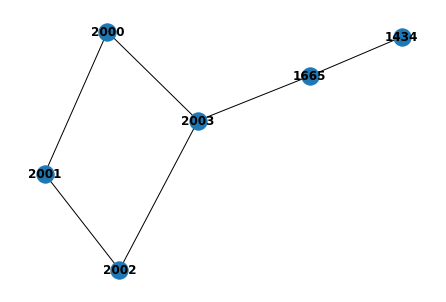

tensor([[2002, 2000, 1665, 1434, 2001, 2000],
        [2003, 2003, 2003, 1665, 2002, 2001]])
f1_score, ged 0.6666666666666666 3.0
[0.14941887 0.44898409 0.14941887 1.         0.44898409 0.88035944
 1.44898409 0.88035944 0.58079422 0.14941887 0.14941887 0.58079422
 1.         1.44898409]


<Figure size 432x288 with 0 Axes>

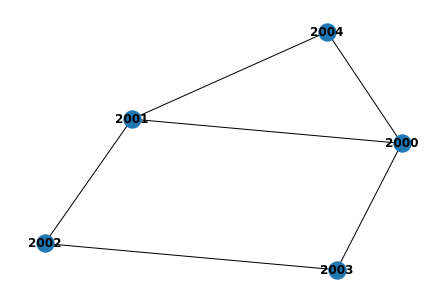

tensor([[2001, 2000, 2001, 2002, 2000, 2000],
        [2004, 2004, 2002, 2003, 2001, 2003]])
f1_score, ged 1.0 0.0
[0.59363772 0.59363772 0.59363772 0.59363772 0.59363772 0.59363772
 0.59363772 0.59363772 0.59363772 0.59363772 1.59363772 2.
 2.         1.99960565 2.         2.         1.99960565 2.
 2.         1.59363772 2.         2.         1.99960565 1.99960565]


<Figure size 432x288 with 0 Axes>

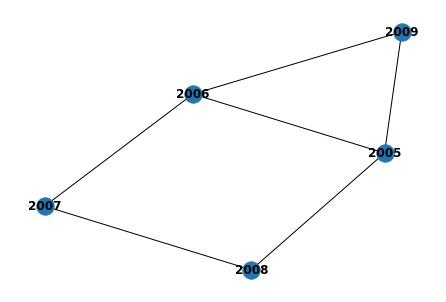

tensor([[2005, 2005, 2006, 2007, 2006, 2005],
        [2008, 2006, 2007, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [36]:
import time 


list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pgmexplainer(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [ ]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

In [80]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision), np.mean(duration_samples))

0.7497902097902097 1.65 0.7249999999999999 0.785357142857143 nan


/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kenzaamara/.conda/envs/Explain/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

[0.29218136 0.15195296 0.23682181 ... 0.65071381 0.36042914 0.02769381]


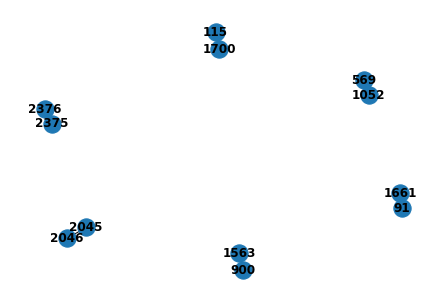

tensor([[2375,   91,  900,  569, 2045,  115],
        [2376, 1661, 1563, 1052, 2046, 1700]])
f1_score, ged 0 15.0
[0.25748322 0.55452075 0.77116991 ... 0.08410639 0.46548574 0.58332501]


<Figure size 432x288 with 0 Axes>

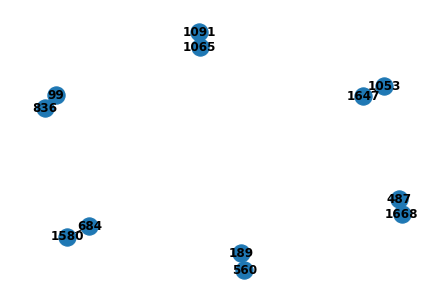

tensor([[  99,  684, 1065, 1053,  189,  487],
        [ 836, 1580, 1091, 1647,  560, 1668]])
f1_score, ged 0 15.0
[0.29058395 0.18983893 0.99145235 ... 0.82166589 0.00548186 0.03905489]


<Figure size 432x288 with 0 Axes>

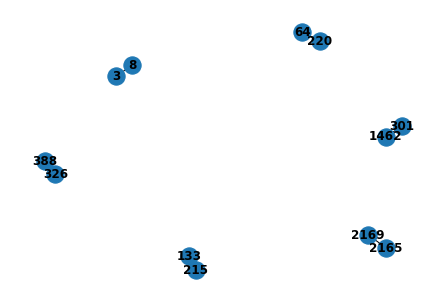

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [45]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_random(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [46]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


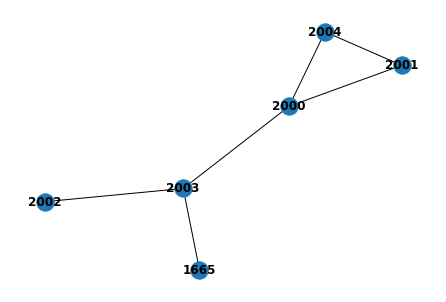

tensor([[1665, 2002, 2000, 2001, 2000, 2000],
        [2003, 2003, 2004, 2004, 2003, 2001]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

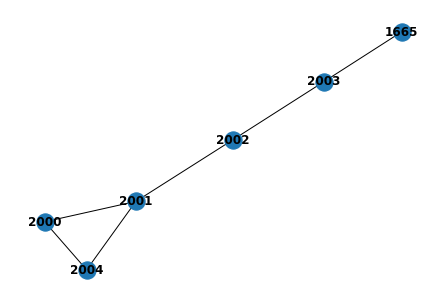

tensor([[2000, 2000, 2001, 2001, 1665, 2002],
        [2001, 2004, 2004, 2002, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

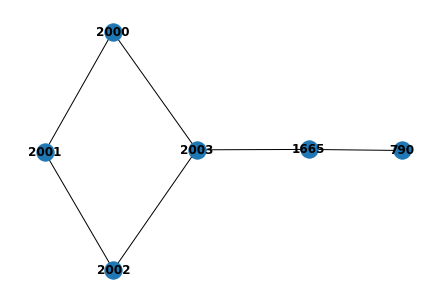

tensor([[2001, 1665, 2002, 2000, 2000,  790],
        [2002, 2003, 2003, 2003, 2001, 1665]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.25       0.25       ... 0.125      0.16666667 0.14285714]


<Figure size 432x288 with 0 Axes>

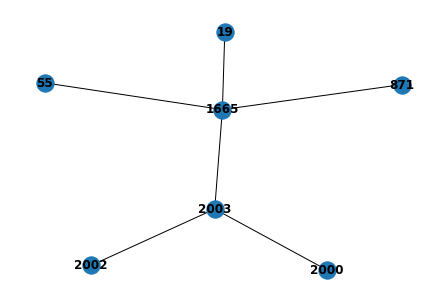

tensor([[1665, 2002, 2000,   55,   19,  871],
        [2003, 2003, 2003, 1665, 1665, 1665]])
f1_score, ged 0.3333333333333333 6.0
[0.14285714 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

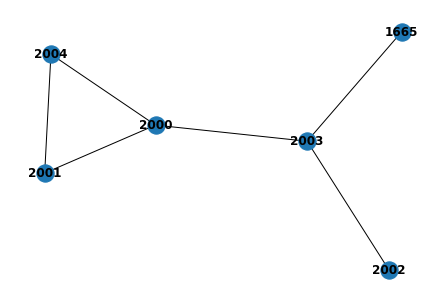

tensor([[2000, 2001, 2000, 1665, 2002, 2000],
        [2004, 2004, 2001, 2003, 2003, 2003]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

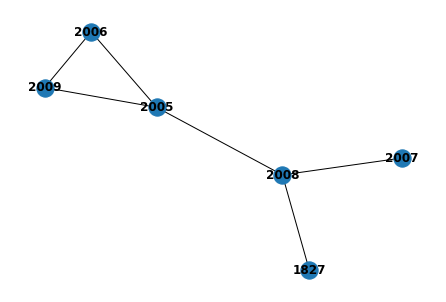

tensor([[2005, 1827, 2007, 2006, 2005, 2005],
        [2006, 2008, 2008, 2009, 2009, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

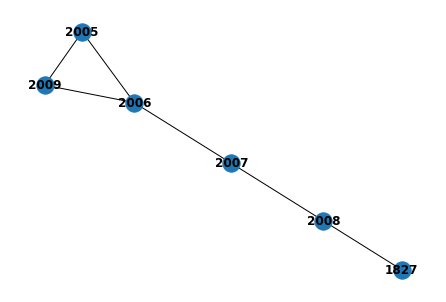

tensor([[2005, 2006, 2006, 2005, 1827, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 0.8333333333333334 3.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

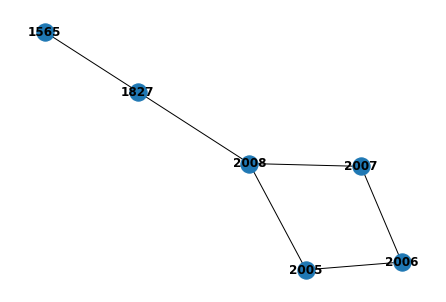

tensor([[2006, 2005, 1827, 2007, 2005, 1565],
        [2007, 2006, 2008, 2008, 2008, 1827]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

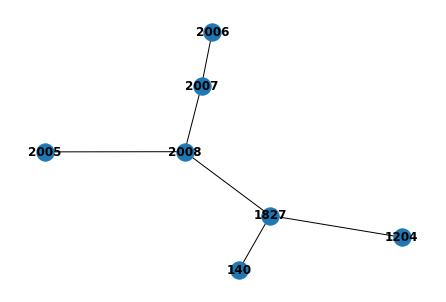

tensor([[2005, 1827, 2007,  140, 1204, 2006],
        [2008, 2008, 2008, 1827, 1827, 2007]])
f1_score, ged 0.5 6.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

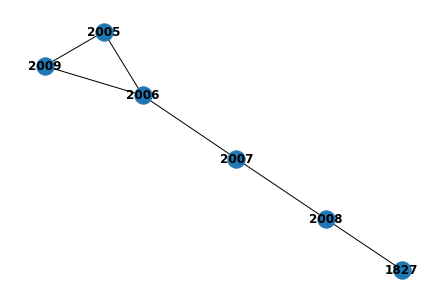

tensor([[2006, 2005, 2005, 1827, 2007, 2006],
        [2009, 2009, 2006, 2008, 2008, 2007]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

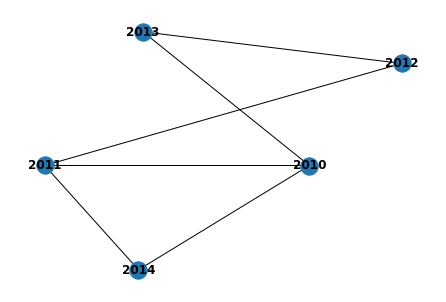

tensor([[2010, 2010, 2011, 2012, 2010, 2011],
        [2013, 2014, 2014, 2013, 2011, 2012]])
f1_score, ged 1.0 0.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

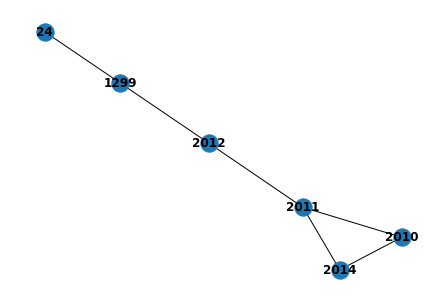

tensor([[2010, 2010, 2011, 2011, 1299,   24],
        [2011, 2014, 2012, 2014, 2012, 1299]])
f1_score, ged 0.6666666666666666 3.0
[0.2        0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

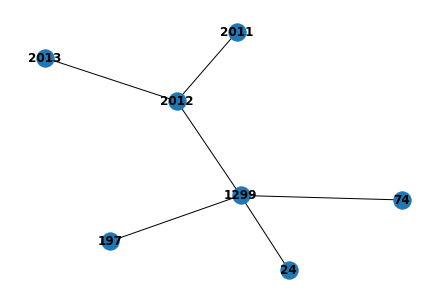

tensor([[2011, 1299,   24, 2012,  197,   74],
        [2012, 2012, 1299, 2013, 1299, 1299]])
f1_score, ged 0.3333333333333333 6.0
[0.16666667 0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

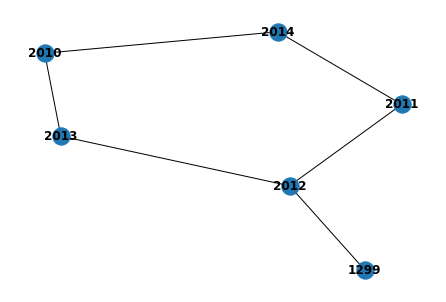

tensor([[2010, 2012, 2011, 1299, 2010, 2011],
        [2013, 2013, 2012, 2012, 2014, 2014]])
f1_score, ged 0.8333333333333334 3.0
[0.14285714 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

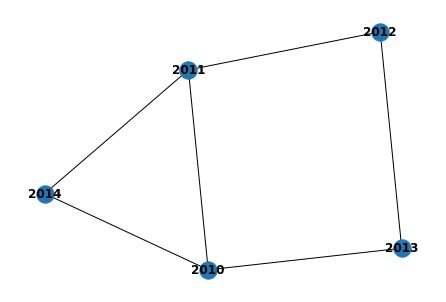

tensor([[2010, 2011, 2010, 2010, 2011, 2012],
        [2014, 2014, 2011, 2013, 2012, 2013]])
f1_score, ged 1.0 0.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

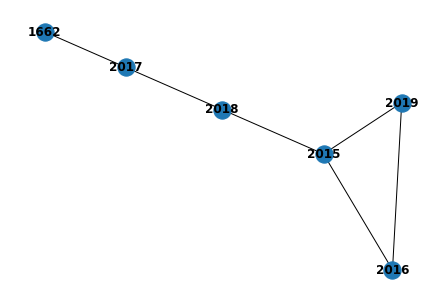

tensor([[2015, 2015, 2016, 2015, 2017, 1662],
        [2019, 2016, 2019, 2018, 2018, 2017]])
f1_score, ged 0.8333333333333334 3.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

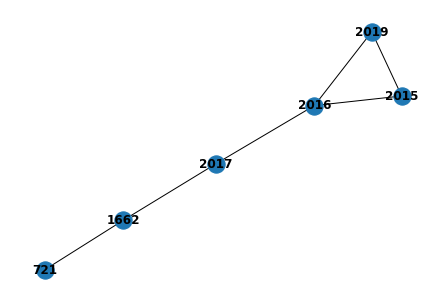

tensor([[2015, 2015, 1662, 2016, 2016,  721],
        [2016, 2019, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 3.0
[0.25       0.2        0.2        ... 0.11111111 0.14285714 0.125     ]


<Figure size 432x288 with 0 Axes>

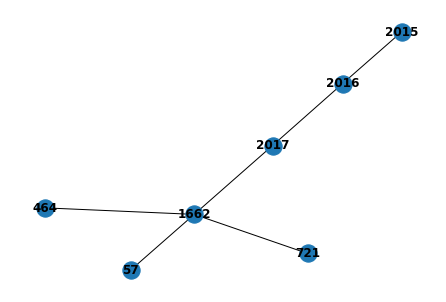

tensor([[2016, 1662,   57, 2015,  464,  721],
        [2017, 2017, 1662, 2016, 1662, 1662]])
f1_score, ged 0.3333333333333333 6.0
[0.2        0.16666667 0.16666667 ... 0.1        0.125      0.11111111]


<Figure size 432x288 with 0 Axes>

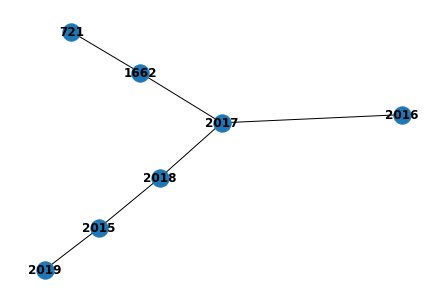

tensor([[2015, 2017, 1662, 2016, 2015,  721],
        [2018, 2018, 2017, 2017, 2019, 1662]])
f1_score, ged 0.6666666666666666 6.0
[0.16666667 0.14285714 0.14285714 ... 0.09090909 0.11111111 0.1       ]


<Figure size 432x288 with 0 Axes>

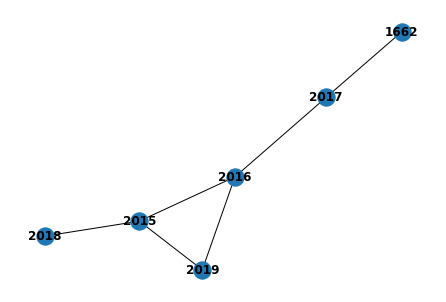

tensor([[2015, 2016, 2015, 1662, 2016, 2015],
        [2019, 2019, 2016, 2017, 2017, 2018]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [47]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_distance(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [48]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

[1.32453888e-03 1.69397530e-03 2.54784989e-03 ... 7.50785614e-06
 1.33518254e-05 9.68526597e-06]


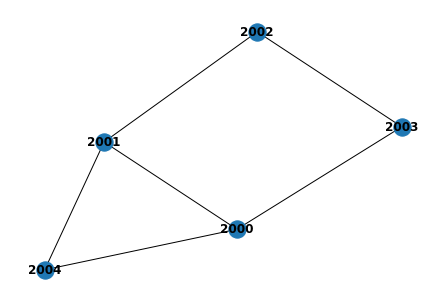

tensor([[2000, 2000, 2000, 2001, 2001, 2002],
        [2001, 2004, 2003, 2004, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.11600353e-03 1.42445958e-03 2.13800134e-03 ... 6.95529024e-06
 1.20614140e-05 8.92237558e-06]


<Figure size 432x288 with 0 Axes>

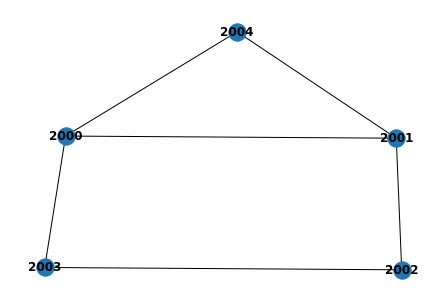

tensor([[2000, 2001, 2001, 2000, 2000, 2002],
        [2001, 2004, 2002, 2004, 2003, 2003]])
f1_score, ged 1.0 0.0
[1.53740046e-03 1.96925299e-03 2.96676362e-03 ... 8.06205697e-06
 1.46552188e-05 1.04518902e-05]


<Figure size 432x288 with 0 Axes>

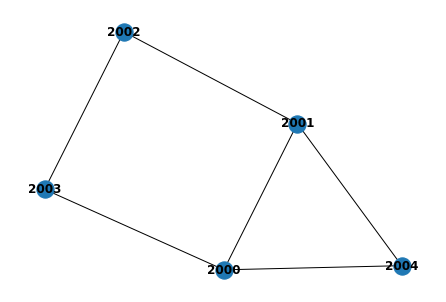

tensor([[2001, 2002, 2000, 2000, 2001, 2000],
        [2002, 2003, 2001, 2003, 2004, 2004]])
f1_score, ged 1.0 0.0
[2.48959870e-03 3.19737775e-03 4.83052295e-03 ... 1.13912594e-05
 2.15790659e-05 1.49084293e-05]


<Figure size 432x288 with 0 Axes>

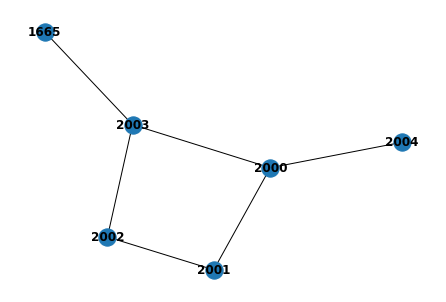

tensor([[2000, 2002, 1665, 2000, 2001, 2000],
        [2003, 2003, 2003, 2001, 2002, 2004]])
f1_score, ged 0.8333333333333334 3.0
[1.04618233e-03 1.33413151e-03 2.00045765e-03 ... 6.77583828e-06
 1.16372338e-05 8.67374532e-06]


<Figure size 432x288 with 0 Axes>

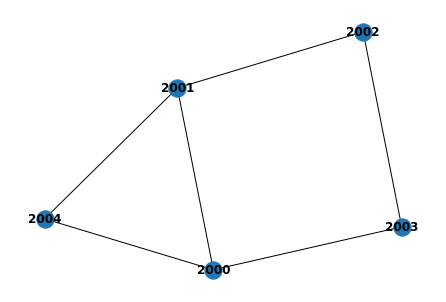

tensor([[2001, 2000, 2000, 2000, 2001, 2002],
        [2004, 2004, 2001, 2003, 2002, 2003]])
f1_score, ged 1.0 0.0
[1.10583891e-03 1.24979465e-03 1.44841009e-03 ... 7.34985856e-06
 1.29791515e-05 9.46644075e-06]


<Figure size 432x288 with 0 Axes>

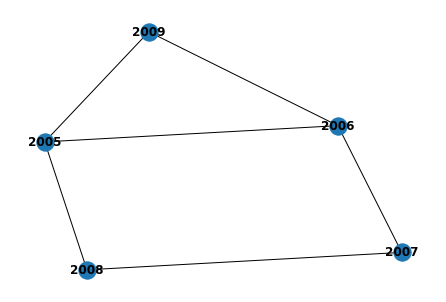

tensor([[2005, 2005, 2005, 2006, 2006, 2007],
        [2006, 2009, 2008, 2009, 2007, 2008]])
f1_score, ged 1.0 0.0
[9.25316400e-04 1.04567418e-03 1.21195350e-03 ... 6.11609110e-06
 1.08199168e-05 7.88050674e-06]


<Figure size 432x288 with 0 Axes>

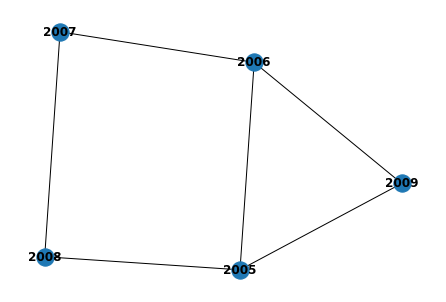

tensor([[2005, 2006, 2006, 2005, 2005, 2007],
        [2006, 2009, 2007, 2009, 2008, 2008]])
f1_score, ged 1.0 0.0
[1.28078357e-03 1.44828793e-03 1.67755761e-03 ... 7.87297539e-06
 1.42123585e-05 1.01904148e-05]


<Figure size 432x288 with 0 Axes>

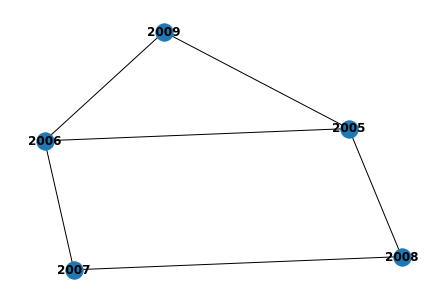

tensor([[2006, 2007, 2005, 2005, 2006, 2005],
        [2007, 2008, 2006, 2008, 2009, 2009]])
f1_score, ged 1.0 0.0
[2.06633050e-03 2.33872893e-03 2.70648849e-03 ... 1.10691951e-05
 2.08329554e-05 1.44643198e-05]


<Figure size 432x288 with 0 Axes>

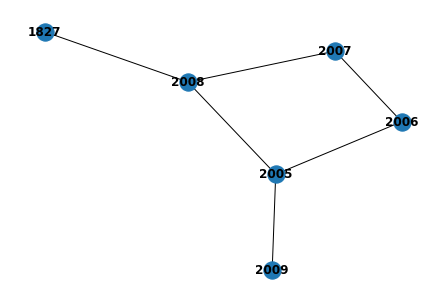

tensor([[2005, 2007, 1827, 2005, 2006, 2005],
        [2008, 2008, 2008, 2006, 2007, 2009]])
f1_score, ged 0.8333333333333334 3.0
[8.67691112e-04 9.80298783e-04 1.13647359e-03 ... 5.94188816e-06
 1.04109897e-05 7.63981236e-06]


<Figure size 432x288 with 0 Axes>

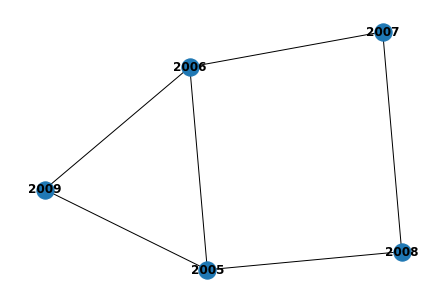

tensor([[2006, 2005, 2005, 2005, 2006, 2007],
        [2009, 2009, 2006, 2008, 2007, 2008]])
f1_score, ged 1.0 0.0
[1.65377137e-03 1.71813456e-03 1.90441342e-03 ... 6.74515672e-06
 1.15672815e-05 8.63167774e-06]


<Figure size 432x288 with 0 Axes>

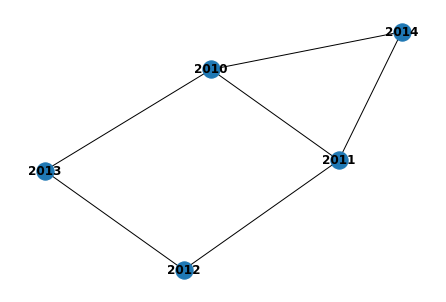

tensor([[2010, 2010, 2010, 2011, 2011, 2012],
        [2011, 2014, 2013, 2014, 2012, 2013]])
f1_score, ged 1.0 0.0
[1.97141972e-03 2.04737839e-03 2.26753949e-03 ... 7.24934231e-06
 1.27500628e-05 9.32854671e-06]


<Figure size 432x288 with 0 Axes>

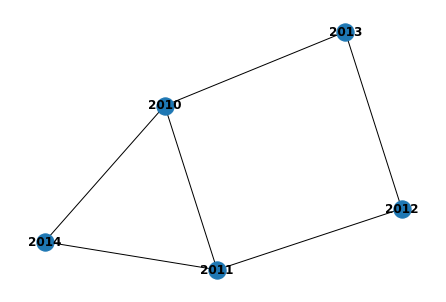

tensor([[2010, 2011, 2011, 2010, 2010, 2012],
        [2011, 2014, 2012, 2014, 2013, 2013]])
f1_score, ged 1.0 0.0
[3.73993962e-03 3.88100145e-03 4.29112664e-03 ... 1.08703802e-05
 2.03883470e-05 1.41929867e-05]


<Figure size 432x288 with 0 Axes>

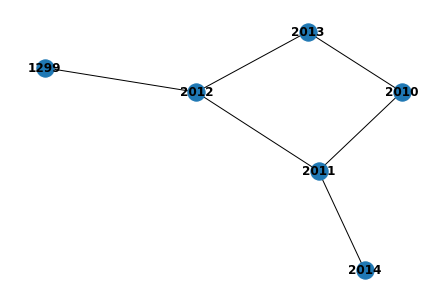

tensor([[2011, 2012, 1299, 2010, 2010, 2011],
        [2012, 2013, 2012, 2011, 2013, 2014]])
f1_score, ged 0.8333333333333334 3.0
[2.29608740e-03 2.38386118e-03 2.63856353e-03 ... 7.75403032e-06
 1.39431600e-05 1.00275987e-05]


<Figure size 432x288 with 0 Axes>

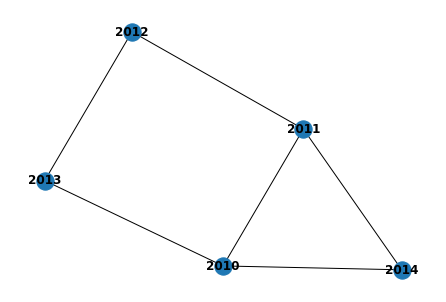

tensor([[2010, 2012, 2010, 2011, 2010, 2011],
        [2013, 2013, 2011, 2012, 2014, 2014]])
f1_score, ged 1.0 0.0
[1.54718860e-03 1.60768123e-03 1.78263570e-03 ... 6.58197222e-06
 1.11793901e-05 8.40524271e-06]


<Figure size 432x288 with 0 Axes>

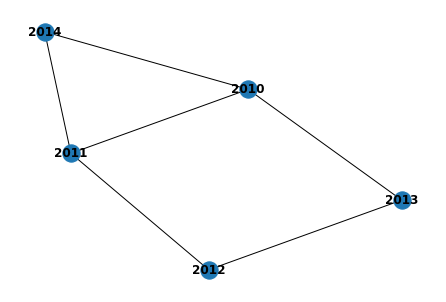

tensor([[2010, 2011, 2010, 2011, 2010, 2012],
        [2014, 2014, 2011, 2012, 2013, 2013]])
f1_score, ged 1.0 0.0
[1.06842299e-03 1.07464209e-03 1.30528532e-03 ... 7.04286122e-06
 1.22708800e-05 9.04436303e-06]


<Figure size 432x288 with 0 Axes>

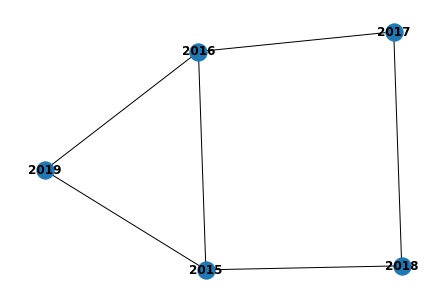

tensor([[2015, 2015, 2015, 2016, 2016, 2017],
        [2016, 2019, 2018, 2019, 2017, 2018]])
f1_score, ged 1.0 0.0
[1.26726652e-03 1.27334980e-03 1.54683762e-03 ... 7.61664186e-06
 1.36094772e-05 9.83570713e-06]


<Figure size 432x288 with 0 Axes>

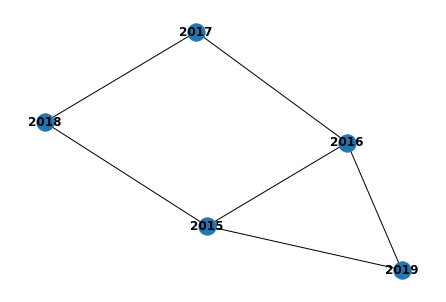

tensor([[2015, 2016, 2016, 2015, 2015, 2017],
        [2016, 2019, 2017, 2019, 2018, 2018]])
f1_score, ged 1.0 0.0
[2.37870386e-03 2.38496700e-03 2.89791356e-03 ... 1.16142031e-05
 2.20951259e-05 1.52149286e-05]


<Figure size 432x288 with 0 Axes>

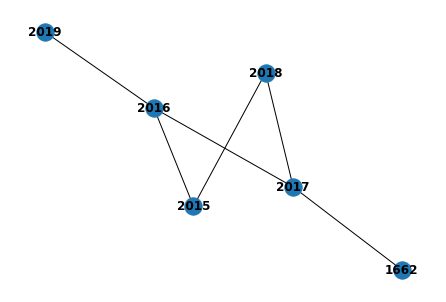

tensor([[2016, 2017, 1662, 2015, 2015, 2016],
        [2017, 2018, 2017, 2016, 2018, 2019]])
f1_score, ged 0.8333333333333334 3.0
[1.47018725e-03 1.47606849e-03 1.79326152e-03 ... 8.19252175e-06
 1.49616176e-05 1.06318333e-05]


<Figure size 432x288 with 0 Axes>

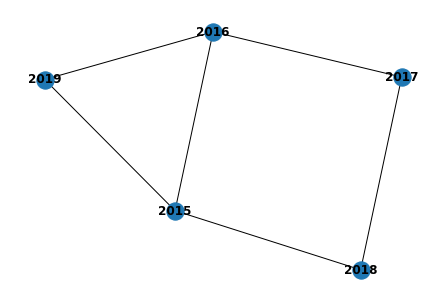

tensor([[2015, 2017, 2015, 2016, 2015, 2016],
        [2018, 2018, 2016, 2017, 2019, 2019]])
f1_score, ged 1.0 0.0
[1.00187901e-03 1.00817722e-03 1.22450018e-03 ... 6.85628102e-06
 1.18311067e-05 8.78573719e-06]


<Figure size 432x288 with 0 Axes>

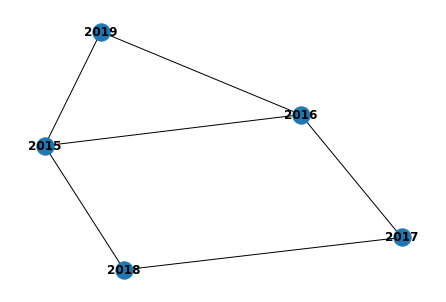

tensor([[2015, 2016, 2015, 2016, 2015, 2017],
        [2019, 2019, 2016, 2017, 2018, 2018]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

In [49]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_pagerank(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [50]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing):
            layers.append(module)
    return layers

In [51]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    node_attr = np.array(node_attrs).mean(axis=0)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [1]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []
duration_samples = []

for node_idx in list_node_idx:
    start_time = time.time()
    edge_mask = explain_gradXact(model, node_idx, data.x, data.edge_index, labels[node_idx])
    print(edge_mask[np.where(edge_mask>0)[0]])
    end_time = time.time()
    duration_seconds = end_time - start_time
    duration_samples.append(duration_seconds)
    
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

NameError: name 'n_basis' is not defined